# Analysis of Gravity-driven Fluid Oscillations in a Drinking Straw

Analysis script for numerical solution of differential equation

In [281]:
# import libraries
import numpy as np
import scipy as sp
from ipywidgets import interact
from scipy.integrate import odeint
from scipy import signal
import matplotlib.pyplot as plt
from scipy import optimize, stats
# This makes the plots appear inside the notebook
%matplotlib inline
plt.rcParams['figure.dpi'] = 300
# plt.rcParams['axes.titlesize'] = 'small'
# # plt.rcParams['figure.titlesize'] = 'normal'
# plt.rcParams['figure.figsize'] = (4,3)
# plt.rc('axes', labelsize=11, titlesize=11) 
# %matplotlib nbagg

## Water
Running with data from the water experiment:

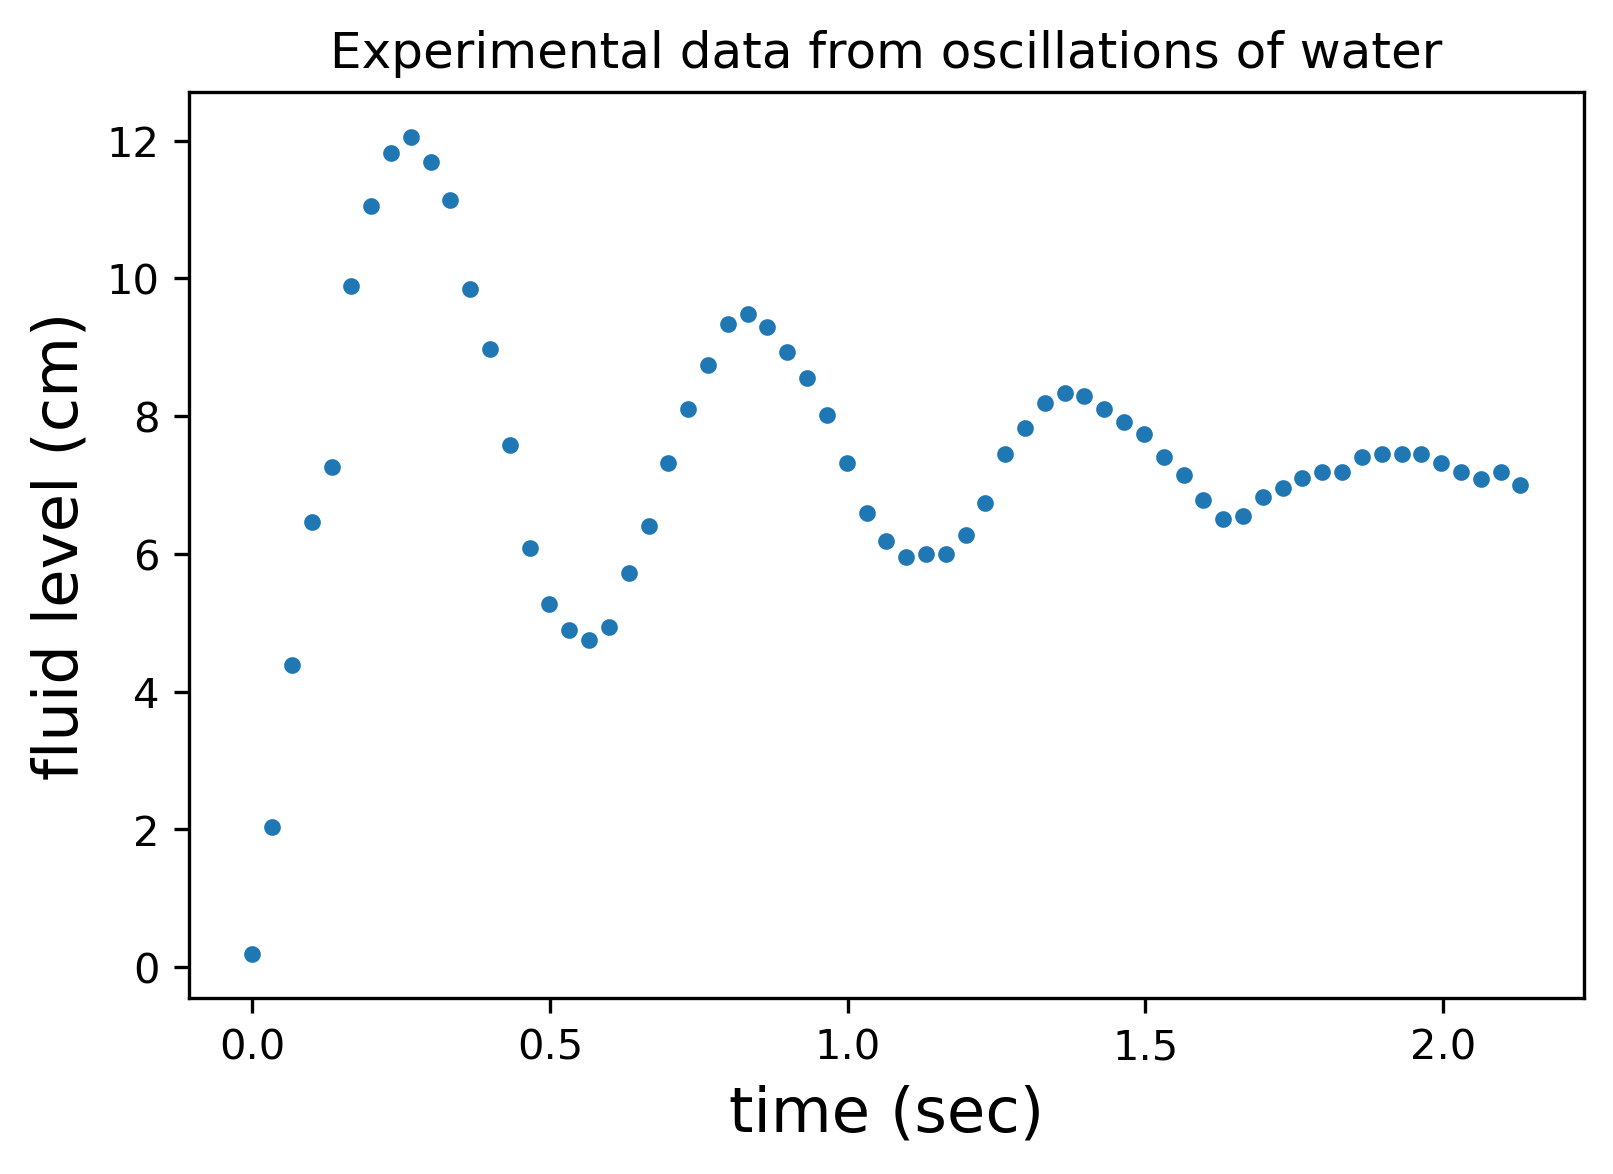

In [389]:
# user-modified area: Import data:
fluid = 'water'
file_dir = './'
filename= f'{fluid}7cm.txt'


data = np.genfromtxt(filename,delimiter='\t',skip_header=2 )
time_data = data[:,0]
x_data = data[:,1]
z_data = data[:,1]*100 # in cm

timeshift = 0 # shifted so that t=0 is the time in video that the cap is released.

time_data_clean = time_data[np.isfinite(z_data)]-timeshift # cleaned data includes the timeshift, and removes any instances of infinite.

z_data_clean = z_data[np.isfinite(z_data)]
z_err = np.array([0.05]*len(z_data_clean))
# print('Time Data: ', time_data_clean)
# print('Z Data: ', z_data_clean)
# print('Z Error: ', z_err)

# plot raw data
plt.errorbar(time_data_clean,z_data_clean, yerr=z_err, fmt='.')
plt.xlabel('time (sec)',fontsize=15)
plt.ylabel('fluid level (cm)',fontsize=15)
plt.title(f'Experimental data from oscillations of {fluid}')
plt.show()

Numerical Solutions

In [303]:
def chi_squared(model_params, model, x_data, y_data, y_error):
    return np.sum(((y_data - model(x_data, *model_params))/y_error)**2)

def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y)

    # now determine nice limits by hand:
    binwidth = 10
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins)
    ax_histy.hist(y, bins=bins, orientation='horizontal')


13.403776108115544
minimised chi-squared = 24501.82250496294
reduced chi^2 for Newton = 382.84097664004594
-3.4135856041239228
minimised chi-squared = 1232581.3828603914
reduced chi^2 for Lorenceau = 19259.084107193616


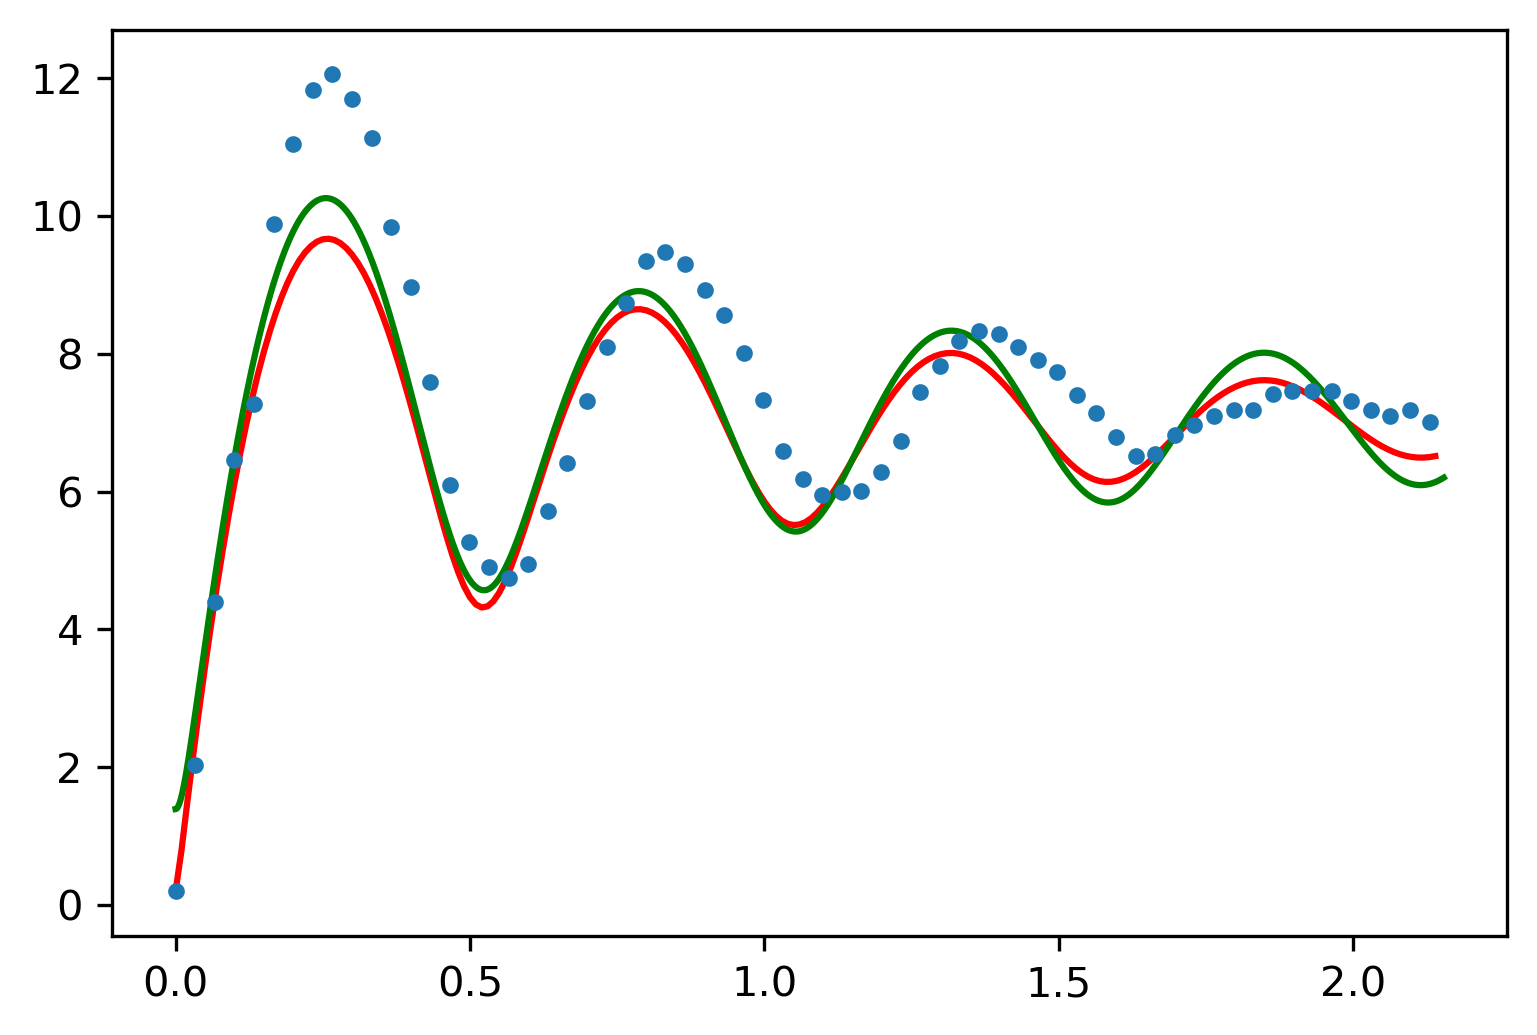

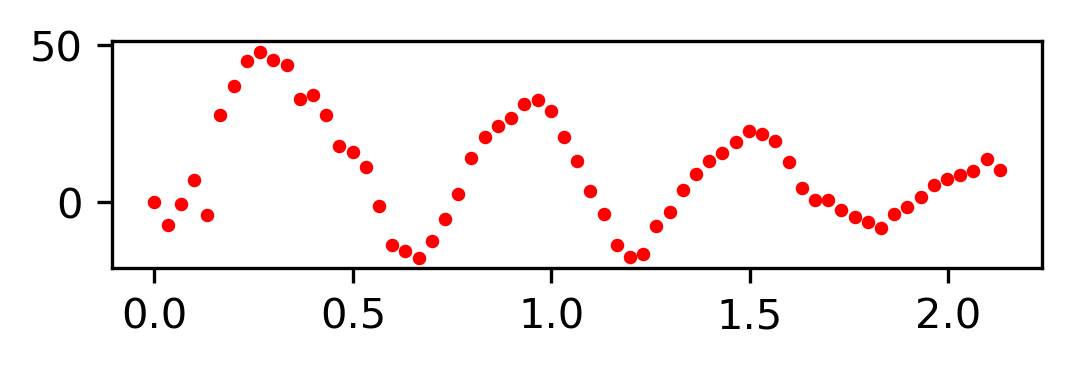

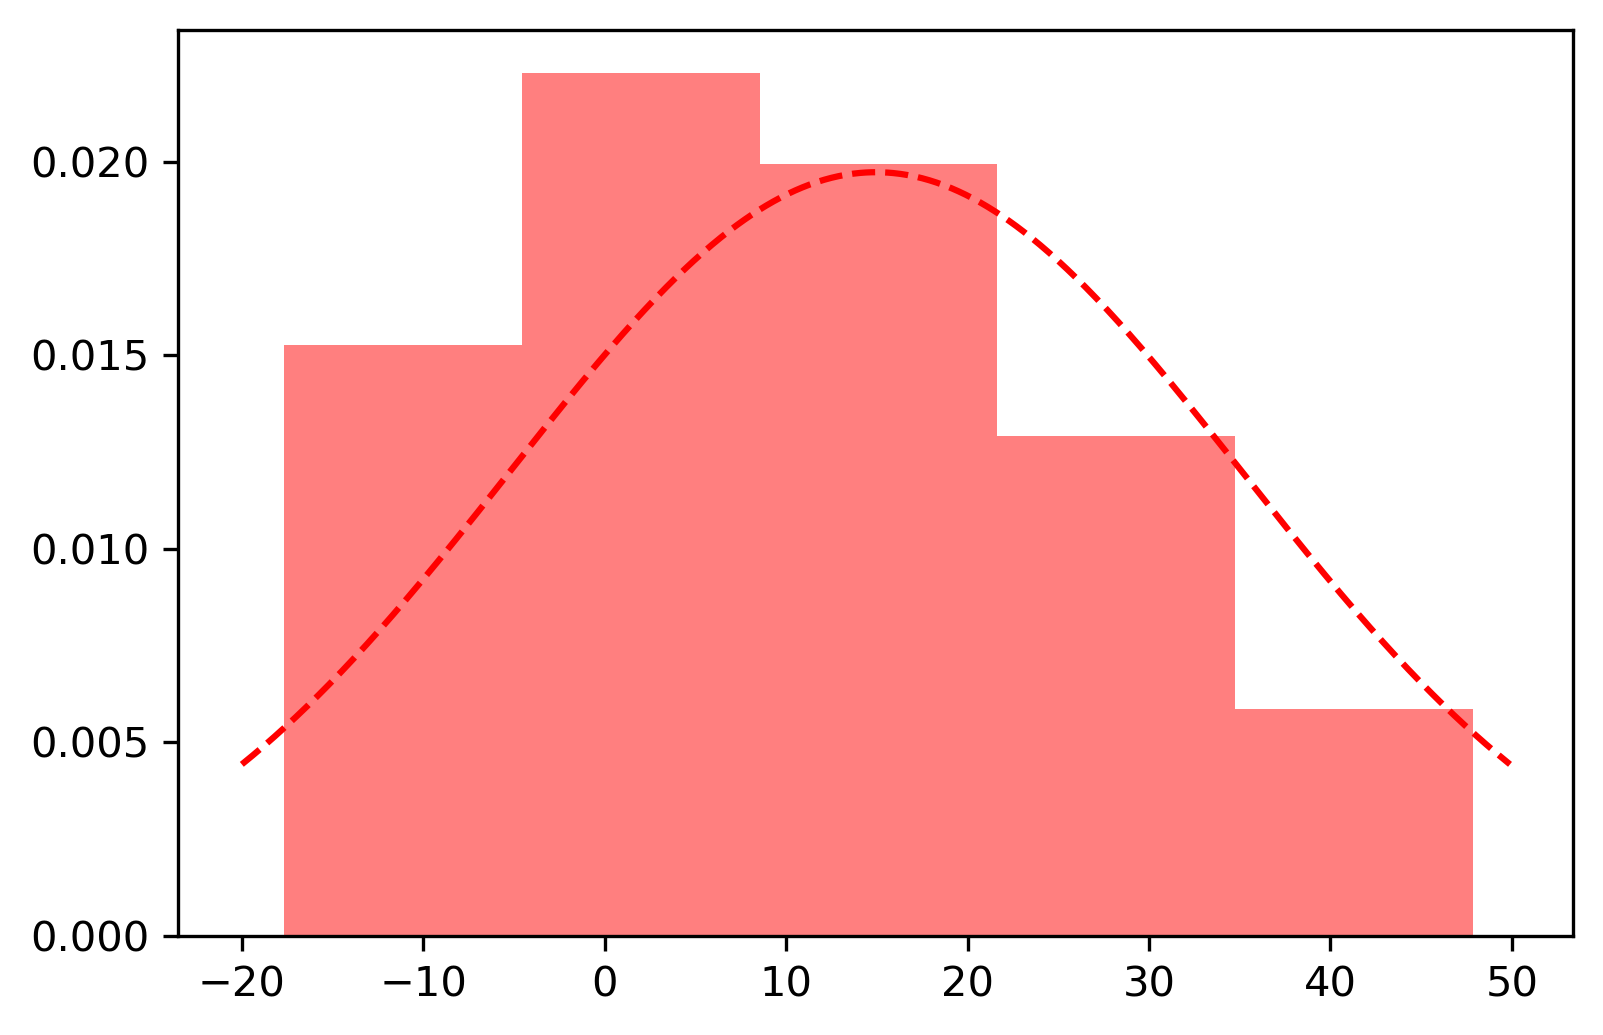

In [319]:
# Plot raw data
plt.errorbar(time_data_clean,z_data_clean, yerr=z_err, fmt='.')

# Newtonian Solution
g = 9.8*100
def DZdt_Newt(Z, t, h, b):
    return [Z[1], -Z[1]**2/Z[0] - g +g*h/Z[0] -b*Z[1]/Z[0]]

Z_intial = [z_data_clean[0], 0]
# Z_intial = [0.1, 0]
h=7
def Newt_solver(tsoln, b):
    return sp.integrate.odeint(DZdt_Newt, Z_intial, tsoln, args=(h,b))[:,0]



initial_values = np.array([1])
popt, pcov = optimize.curve_fit(Newt_solver, 
                        time_data_clean,
                        z_data_clean,
                        absolute_sigma=True, # Don't forget this!
                        p0=initial_values,
                        maxfev=500000)

b_solution = popt[0]

print(b_solution)
t_soln_Newt = np.arange(0, 2.15, 0.01)


z_soln_Newt = sp.integrate.odeint(DZdt_Newt, Z_intial, t_soln_Newt, args=(h,b_solution))[:,0]

res_calc_Newt = sp.integrate.odeint(DZdt_Newt, Z_intial, time_data_clean, args=(h,b_solution))[:,0]
res_Newton = (z_data_clean - res_calc_Newt)/z_err
chisq_min = chi_squared([b_solution], # pass the array - no need to unpack
                        Newt_solver, 
                        time_data_clean, 
                        z_data_clean, 
                        z_err)
print('minimised chi-squared = {}'.format(chisq_min))
deg_freedom = z_data_clean.size - initial_values.size # Make sure you understand why!
chisq_reduced = chisq_min/deg_freedom
print('reduced chi^2 for Newton = {}'.format(chisq_reduced))

plt.plot(t_soln_Newt,z_soln_Newt,'r',label='Newtonian model')

# Lorenceau Solution
def DZdt_Loren(Z, t, omega):
    if Z[1]>0:
        return [Z[1], 1/Z[0] - 1 -omega*Z[1] - (Z[1])**2/Z[0]]
    else:
        return [Z[1], 1/Z[0] - 1 -omega*Z[1] ]

def Lorenceau_solver(t, omega):
    return sp.integrate.odeint(DZdt_Loren, Z_intial, t, args=(omega,))[:,0]

Z_intial = [z_data_clean[0], 0]
initial_values = np.array([2])
popt, pcov = optimize.curve_fit(Lorenceau_solver, 
                        time_data_clean,
                        z_data_clean,
                        absolute_sigma=True, # Don't forget this!
                        p0=initial_values,
                        maxfev=5000)

omega_solution = popt[0]
t_soln_Lor = np.arange(0, 25.5, 0.01)
Z_intial = [z_data_clean[0], 0]
print(omega_solution)
z_soln_Lor = sp.integrate.odeint(DZdt_Loren, Z_intial, t_soln_Lor, args=(0.016,))[:,0]*h
res_calc_Lor = sp.integrate.odeint(DZdt_Loren, Z_intial, time_data_clean, args=(0.016,))[:,0]*h
res_Lor = (z_data_clean - res_calc_Lor)/z_err

chisq_min = chi_squared([0.016], # pass the array - no need to unpack
                        Lorenceau_solver, 
                        time_data_clean, 
                        z_data_clean, 
                        z_err)
print('minimised chi-squared = {}'.format(chisq_min))
deg_freedom = z_data_clean.size - initial_values.size # Make sure you understand why!
chisq_reduced = chisq_min/deg_freedom
print('reduced chi^2 for Lorenceau = {}'.format(chisq_reduced))

plt.plot(t_soln_Lor*(h*1e-2/9.8)**0.5,z_soln_Lor,'g',label='Lorenceau model')
plt.show()



    


plt.figure(figsize=(4, 1), dpi=300)
plt.scatter(time_data_clean, res_Newton, c='r', s=5)
# plt.scatter(time_data_clean*(h*1e0/9.8)**0.5, res_Lor, c='g')

plt.show()

x_axis = np.arange(-20, 50, 0.1)
import statistics
# Calculating mean and standard 
# deviation
mean = statistics.mean(x_axis)
sd = statistics.stdev(x_axis)
from scipy.stats import norm
plt.hist(res_Newton, bins=5, color='r', alpha=0.5, density=True)
plt.plot(x_axis, norm.pdf(x_axis, mean, sd), 'r--')
plt.show()


# # definitions for the axes
# left, width = 0.1, 0.65
# bottom, height = 0.1, 0.65
# spacing = 0.005


# rect_scatter = [left, bottom, width, height]
# rect_histx = [left, bottom + height + spacing, width, 0.2]
# rect_histy = [left + width + spacing, bottom, 0.2, height]

# # start with a square Figure
# fig = plt.figure(figsize=(8, 8))

# ax = fig.add_axes(rect_scatter)
# ax_histx = fig.add_axes(rect_histx, sharex=ax)
# ax_histy = fig.add_axes(rect_histy, sharey=ax)

# # use the previously defined function
# scatter_hist(time_data_clean, res_Newton, ax, ax_histx, ax_histy)

# plt.show()

^ 
Figure 1: Fit of both Newtonian and Lorenceau models to the oscillation of water at 20 degrees C in a straw. Normalised residuals shown for only the Newtonian model as the Lorenceau residuals were too large, particularly for later oscillations. Distribution of normalised residuals vs. the standard normal distribution $Z \sim \mathcal{N}(0,1)$ shown as a dashed line.

Now, we analyse the power spectrum of this oscillation, and fit it to a Lorentzian Profile (Gruberbauer et al. 2009)

$$
L(f) = \frac{A \Gamma^2}{\Gamma^2 + (f-f_0)^2}
$$

Where $f_0$ is the peak frequency obtained from the fitted Lorentzian. This is fitted using `scipy.curve_fit` which uses the non-linear least squares algorithm. Amplitude of the power spectrum measured in arbitrary units.

Sampling frequency is calculated from the average time between data points. As expected from a 30 f.p.s. smartphone camera, this is 30.0Hz (to 1 d.p.)

References:
Gruberbauer, M., Kallinger, T., Weiss, W. W., & Guenther, D. B. (2009). On the detection of Lorentzian profiles in a power spectrum: a Bayesian approach using ignorance priors. Astronomy & Astrophysics, 506(2), 1043-1053.

Avergae interval between samples:  0.03328434628392074
Average sampling frequency:  30.044153232568902


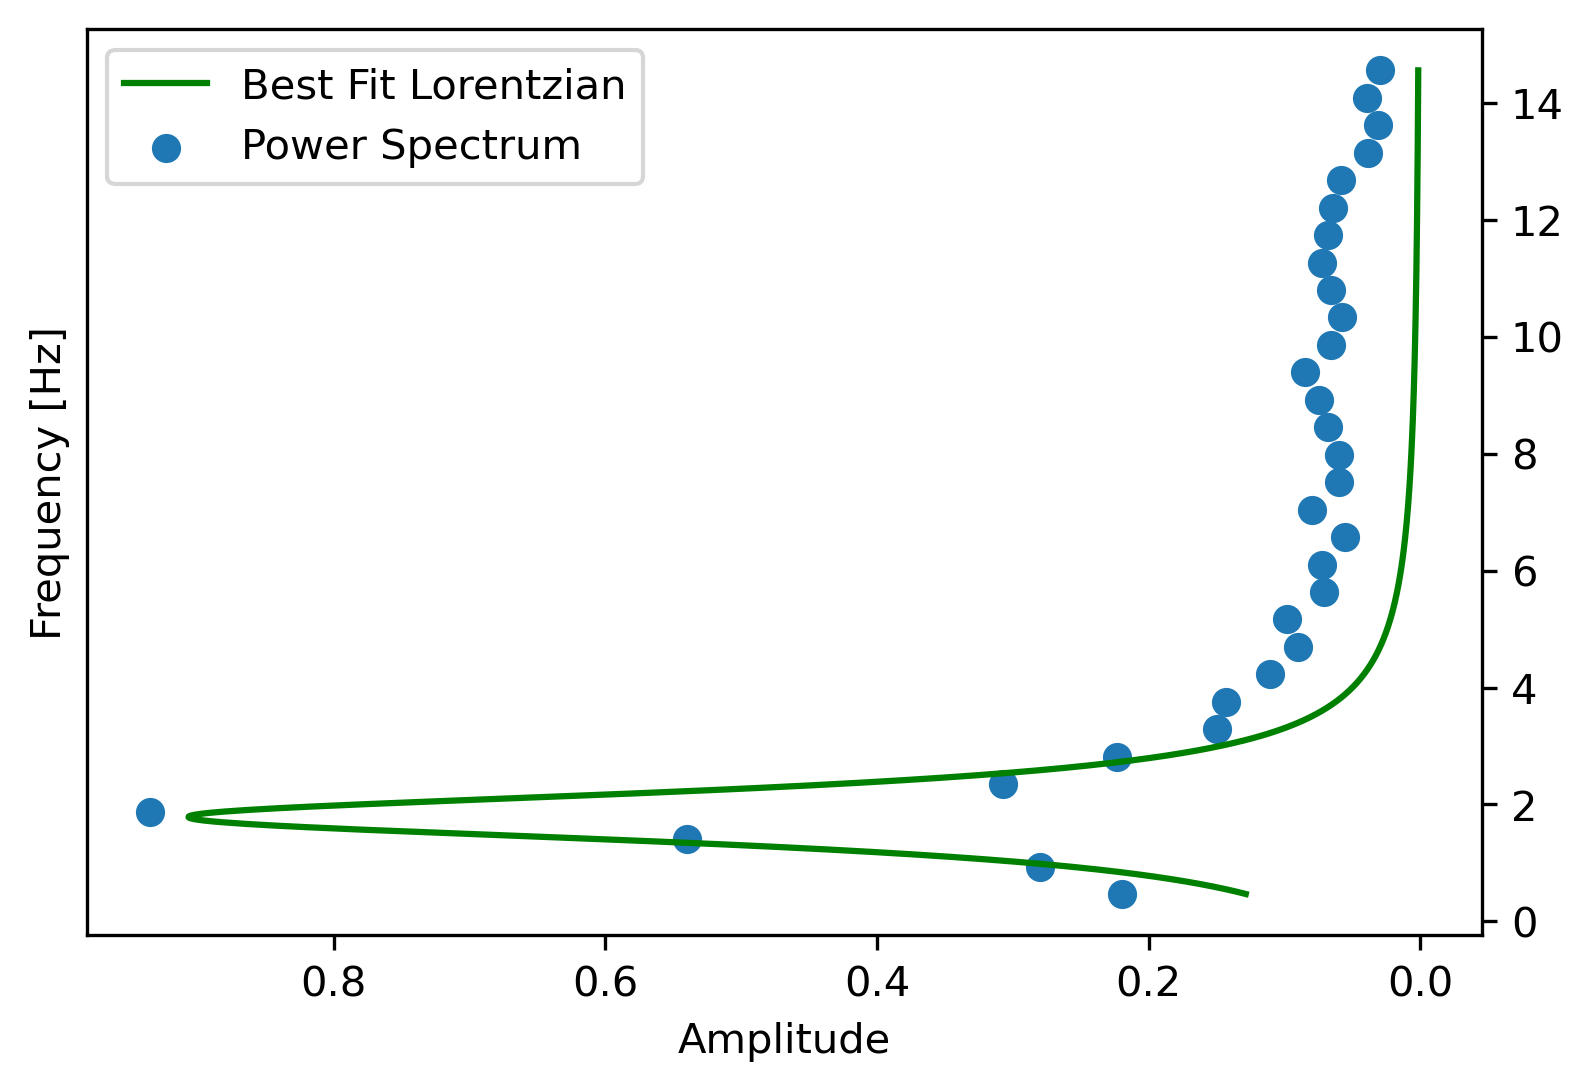

Peak of Lorentzian Profile = 1.79 Hz
FWHM = 1.07 Hz
Amplitude = 0.91


In [339]:
# FFT on raw data
# calculate avergae sampling rate
sum = 0
for i in range(len(time_data_clean)-1):
    sum += time_data_clean[i+1]-time_data_clean[i]


avg_time_between_samples = sum/(len(time_data_clean)-1)
print('Avergae interval between samples: ', avg_time_between_samples)

samplingFrequency   = 1/avg_time_between_samples
print('Average sampling frequency: ', samplingFrequency)


# Compute Fourier transform for Power Spectrum
zs = z_data_clean[1:]
ts = time_data_clean[1:]

fourierTransform = np.fft.fft(zs)/len(zs)           # Normalize amplitude
fourierTransform = fourierTransform[range(int(len(zs)/2))] # Exclude sampling frequency

tpCount     = len(zs)
values      = np.arange(int(tpCount/2))
timePeriod  = tpCount/samplingFrequency
frequencies = values/timePeriod

# Frequency domain representation
# ignore peak at 0 Hz - this is caused by DC signal bias
# occurs when the signal encloses more area above the time axis than below
fourierTransform = fourierTransform[1:]
frequencies = frequencies[1:]

# Lorentzian profile to fit Power spectrum
def lorentzian(f, f0, A, gamma):
    return A * gamma**2 / (gamma**2 + (f-f0)**2)

initial_values = np.array([1, 1, 1])
popt, pcov = optimize.curve_fit(lorentzian, 
                        frequencies,
                        abs(fourierTransform),
                        absolute_sigma=True, # Don't forget this!
                        p0=initial_values,
                        maxfev=500000)

f0_solution, A_solution, gamma_solution = popt

smooth_fvals = np.linspace(min(frequencies), max(frequencies), 1000) 
smooth_lorentz = lorentzian(smooth_fvals, *popt)  

max_freq_component = frequencies[np.argmax(abs(fourierTransform))]
plt.scatter(abs(fourierTransform), frequencies, label='Power Spectrum')
plt.plot(smooth_lorentz, smooth_fvals, label='Best Fit Lorentzian', color='g')
plt.tick_params(axis='y', which='both', labelleft=False, labelright=True, left=False, right=True)
# x1,x2,y1,y2 = plt.axis()  
# plt.axis((0,10,y1,1))
plt.gca().invert_xaxis()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Amplitude')

plt.legend()
plt.show()

print(f'Peak of Lorentzian Profile = {f0_solution:0.2f} Hz')
print(f'FWHM = {2*gamma_solution:0.2f} Hz')
print(f'Amplitude = {A_solution:0.2f}')
fp_w20 = f0_solution # water at 20 degrees peak freq
fwhm_w20 = 2*gamma_solution

Spectrogram for this oscillation. need to figure out which `nperseg` works best. Largest possible is `nperseg` = 34

Interesting emergance of frequencies at 4, 9 and 13 Hz

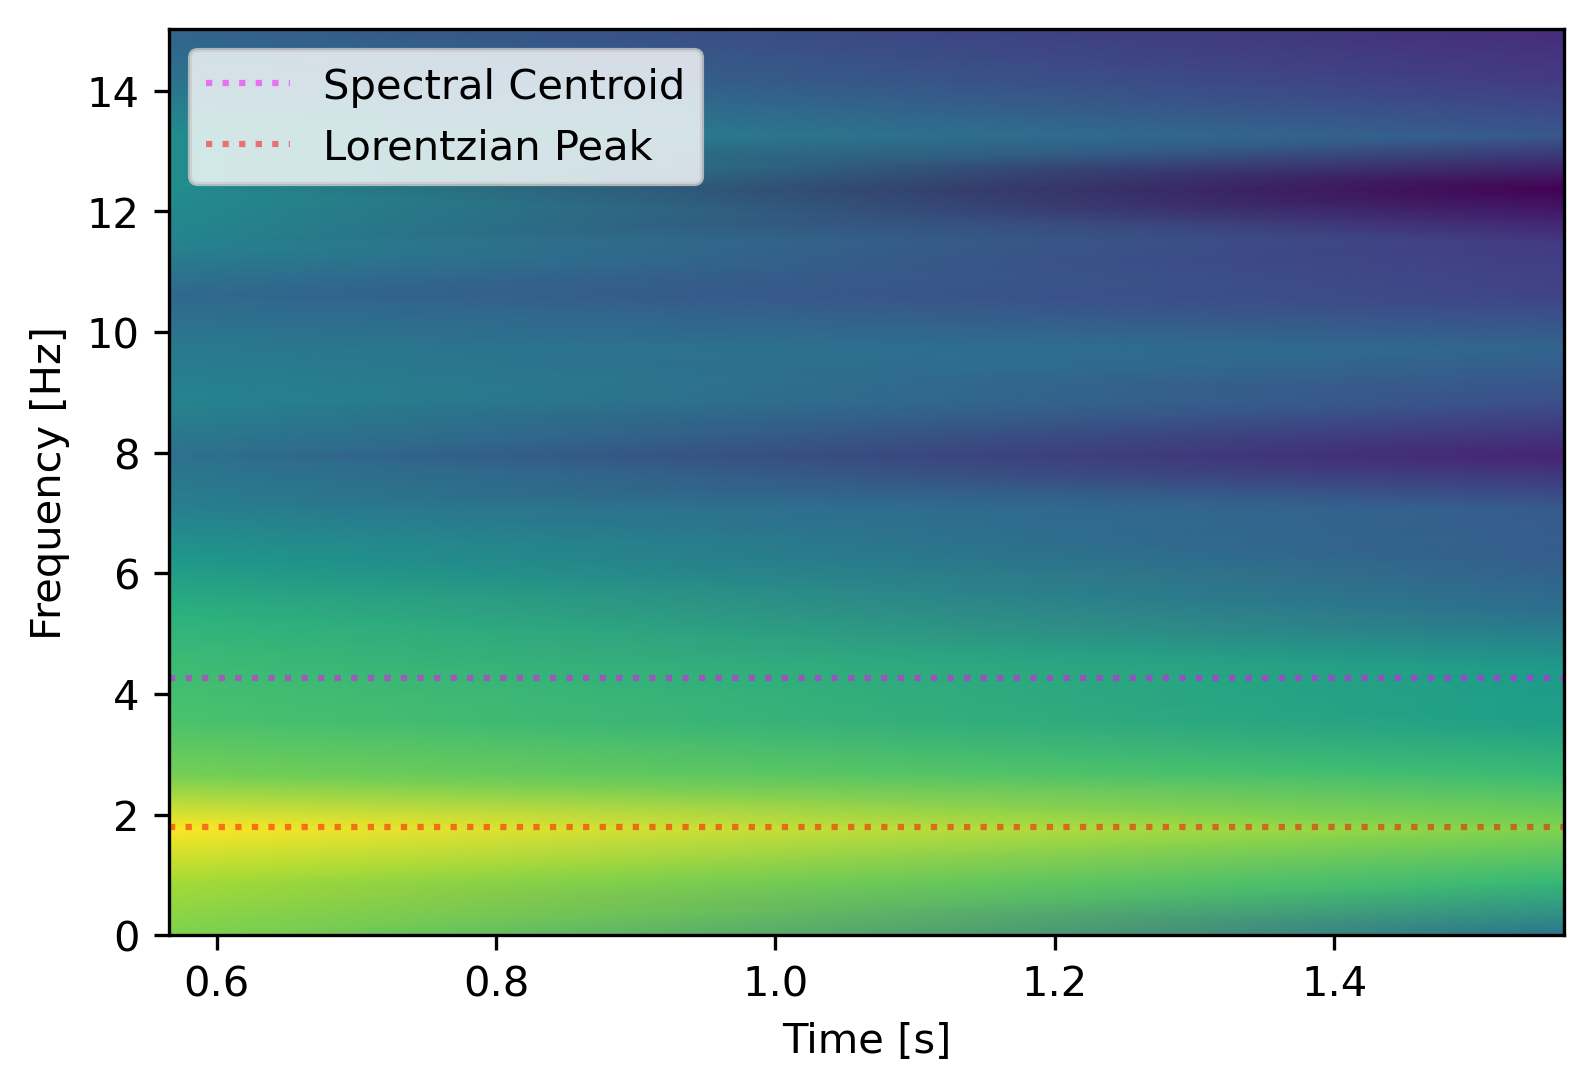

In [340]:
def centroid(fs, xs):
    return (np.dot(fs, xs)/np.sum(xs))

spec_cent = centroid(frequencies, abs(fourierTransform))

f, t, Sxx = signal.spectrogram(z_data_clean, samplingFrequency, nperseg=34)
plt.pcolormesh(t, f, np.log(Sxx), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.axhline(y=spec_cent, color='fuchsia', linestyle=':', label='Spectral Centroid', alpha=0.5)
plt.axhline(y=f0_solution, color='r', linestyle=':', label='Lorentzian Peak', alpha=0.5)
plt.legend(loc='upper left')


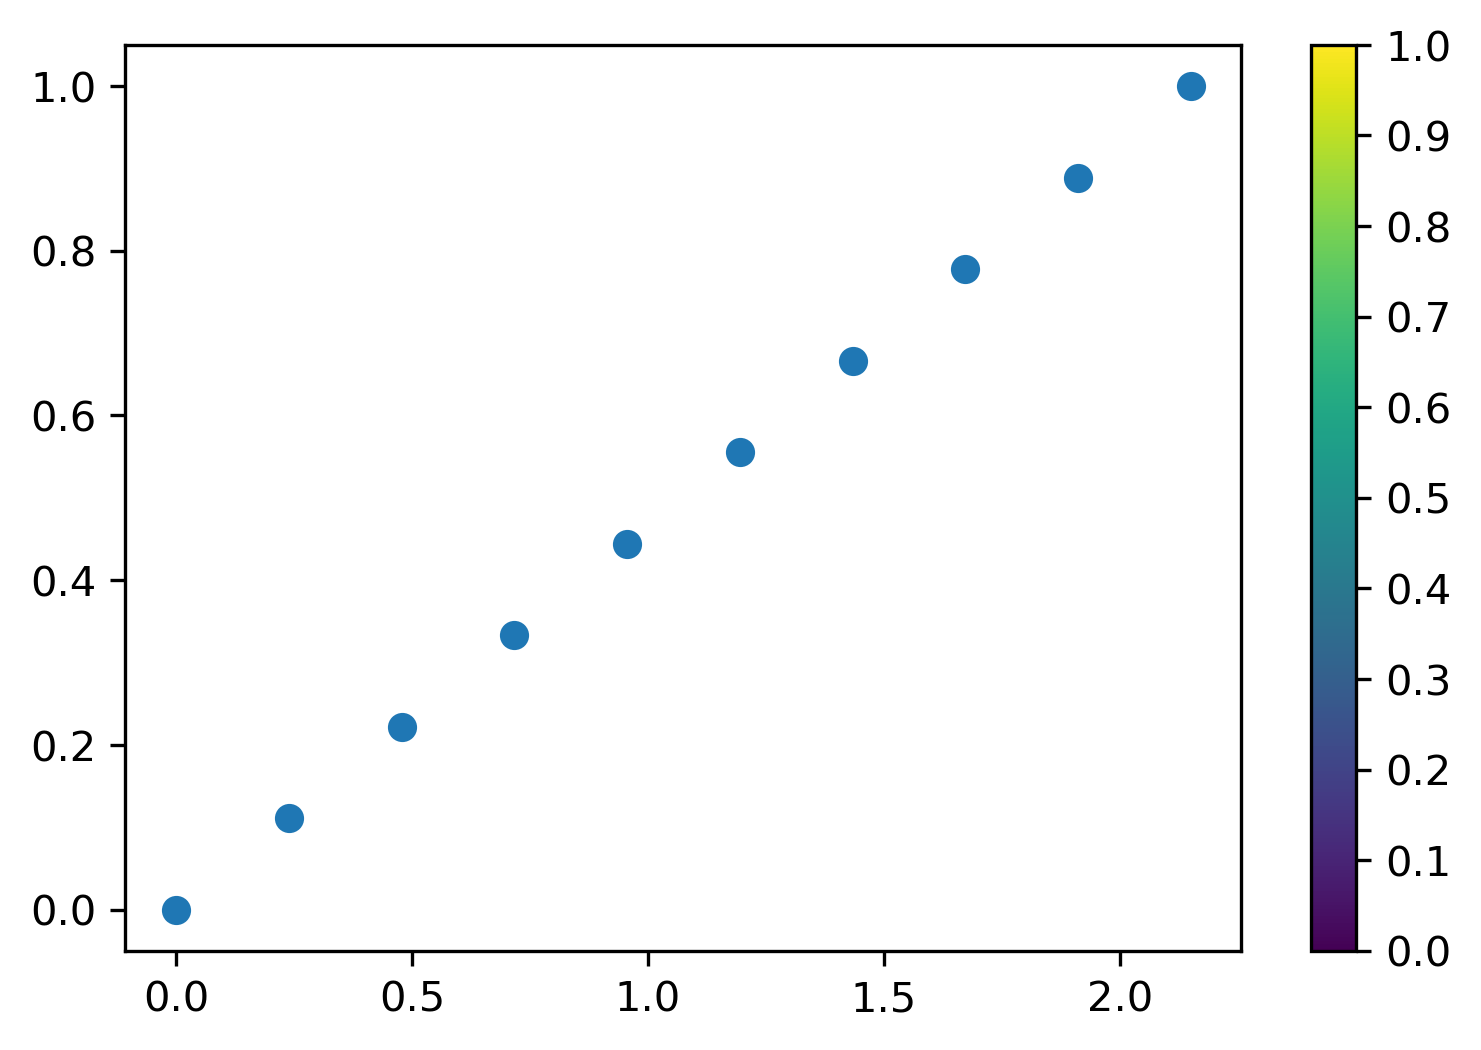

In [338]:
v = np.arange(0, 1.1, 0.1,)
plt.scatter(np.linspace(0,2.15,10), np.linspace(0,1,10))
plt.colorbar(ticks=v)
plt.show()

^
Figure 2
(a) power sprectrum showing the initial distribution of frequencies
(b) Spectrogram showing time evolution in frequency domain

## Milk

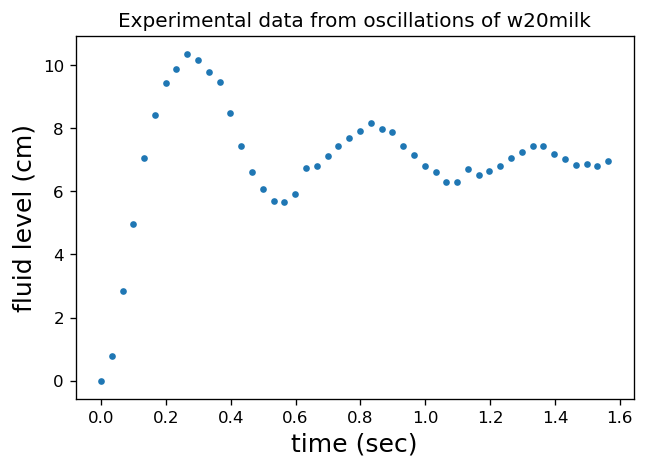

In [256]:
# user-modified area: Import data:
fluid = 'w20milk'
file_dir = './'
filename= f'{fluid}7cm.txt'


data = np.genfromtxt(filename,delimiter='\t',skip_header=2 )
time_data = data[:,0]
x_data = data[:,1]
z_data = data[:,1]*100 # in cm

timeshift = 0 # shifted so that t=0 is the time in video that the cap is released.

time_data_clean = time_data[np.isfinite(z_data)]-timeshift # cleaned data includes the timeshift, and removes any instances of infinite.

z_data_clean = z_data[np.isfinite(z_data)]
z_err = np.array([0.05]*len(z_data_clean))


# plot raw data
plt.errorbar(time_data_clean,z_data_clean, yerr=z_err, fmt='.')
plt.xlabel('time (sec)',fontsize=15)
plt.ylabel('fluid level (cm)',fontsize=15)
plt.title(f'Experimental data from oscillations of {fluid}')
plt.show()

In [257]:
z_data_clean = z_data_clean[1:]
time_data_clean = time_data_clean[1:]
z_err = z_err[1:]

18.921862799330746
4.440892098500626e-16


/Users/kevinroice/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


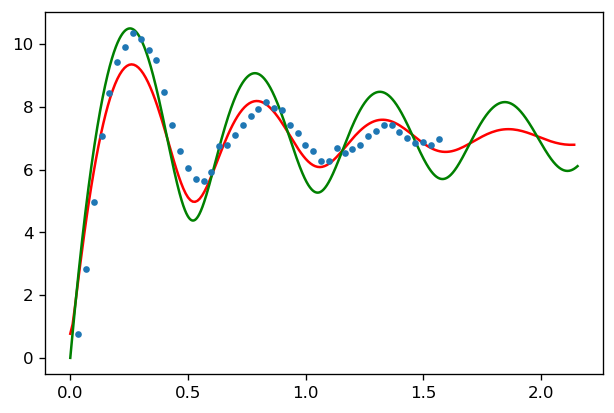

In [260]:
# Plot raw data
plt.errorbar(time_data_clean,z_data_clean, yerr=z_err, fmt='.')


# Newtonian Solution
g = 9.8*100
def DZdt_Newt(Z, t, h, b):
    return [Z[1], -Z[1]**2/Z[0] - g +g*h/Z[0] -b*Z[1]/Z[0]]

Z_intial = [z_data_clean[0], 0]
# Z_intial = [0.1, 0]
h=7
def Newt_solver(tsoln, b):
    return sp.integrate.odeint(DZdt_Newt, Z_intial, tsoln, args=(h,b))[:,0]



initial_values = np.array([1])
popt, pcov = optimize.curve_fit(Newt_solver, 
                        time_data_clean,
                        z_data_clean,
                        absolute_sigma=True, # Don't forget this!
                        p0=initial_values,
                        maxfev=500000)

b_solution = popt[0]

print(b_solution)
t_soln_Newt = np.arange(0, 2.15, 0.01)


z_soln_Newt = sp.integrate.odeint(DZdt_Newt, Z_intial, t_soln_Newt, args=(h,b_solution))[:,0]
plt.plot(t_soln_Newt,z_soln_Newt,'r',label='Newtonian model')

# Lorenceau Solution
def DZdt_Loren(Z, t, omega):
    if Z[1]>0:
        return [Z[1], 1/Z[0] - 1 -omega*Z[1] - (Z[1])**2/Z[0]]
    else:
        return [Z[1], 1/Z[0] - 1 -omega*Z[1] ]

def Lorenceau_solver(t, omega):
    return sp.integrate.odeint(DZdt_Loren, Z_intial, t, args=(omega,))[:,0]

Z_intial = [z_data_clean[0], 0]
initial_values = np.array([2])
popt, pcov = optimize.curve_fit(Lorenceau_solver, 
                        time_data_clean,
                        z_data_clean,
                        absolute_sigma=True, # Don't forget this!
                        p0=initial_values,
                        maxfev=5000)

omega_solution = popt[0]
t_soln_Lor = np.arange(0, 25.5, 0.01)
Z_intial = [0.001, 0]
print(omega_solution)
z_soln_Lor = sp.integrate.odeint(DZdt_Loren, Z_intial, t_soln_Lor, args=(omega_solution,))[:,0]*h
plt.plot(t_soln_Lor*(h*1e-2/9.8)**0.5,z_soln_Lor,'g',label='Lorenceau model')

Avergae interval between samples:  0.0332843462826087
Average sampling frequency:  30.044153233753217
1.8596639597094053


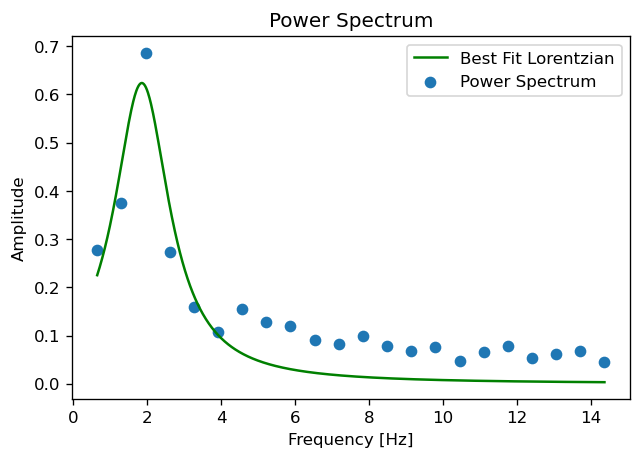

Peak of Lorentzian Profile = 1.86 Hz
FWHM = 1.81 Hz
Amplitude = 0.62


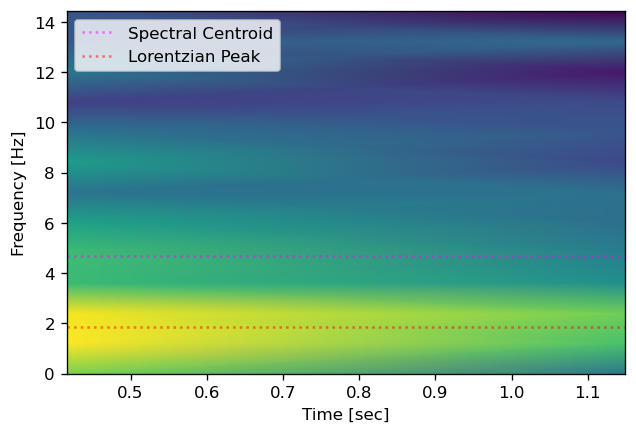

In [261]:
# FFT on raw data
# calculate avergae sampling rate
sum = 0
for i in range(len(time_data_clean)-1):
    sum += time_data_clean[i+1]-time_data_clean[i]


avg_time_between_samples = sum/(len(time_data_clean)-1)
print('Avergae interval between samples: ', avg_time_between_samples)

samplingFrequency   = 1/avg_time_between_samples
print('Average sampling frequency: ', samplingFrequency)

# Compute Fourier transform for Power Spectrum
# ignore t = 0
zs = z_data_clean[1:]
ts = time_data_clean[1:]

fourierTransform = np.fft.fft(zs)/len(zs)           # Normalize amplitude
fourierTransform = fourierTransform[range(int(len(zs)/2))] # Exclude sampling frequency

tpCount     = len(zs)
values      = np.arange(int(tpCount/2))
timePeriod  = tpCount/samplingFrequency
frequencies = values/timePeriod

# Frequency domain representation
# ignore peak at 0 Hz - this is caused by DC signal bias
# occurs when the signal encloses more area above the time axis than below
fourierTransform = fourierTransform[1:]
frequencies = frequencies[1:]

# Lorentzian profile to fit Power spectrum
def lorentzian(f, f0, A, gamma):
    return A * gamma**2 / (gamma**2 + (f-f0)**2)

initial_values = np.array([1, 1, 1])
popt, pcov = optimize.curve_fit(lorentzian, 
                        frequencies,
                        abs(fourierTransform),
                        absolute_sigma=True, # Don't forget this!
                        p0=initial_values,
                        maxfev=500000)

f0_solution, A_solution, gamma_solution = popt

fp_milk = f0_solution
fwhm_milk = 2*gamma_solution
print(fp_milk)

smooth_fvals = np.linspace(min(frequencies), max(frequencies), 1000) 
smooth_lorentz = lorentzian(smooth_fvals, *popt)  

max_freq_component = frequencies[np.argmax(abs(fourierTransform))]


plt.title(f'Power Spectrum')
plt.scatter(frequencies, abs(fourierTransform), label='Power Spectrum')
plt.plot(smooth_fvals, smooth_lorentz, label='Best Fit Lorentzian', color='g')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')

plt.legend()
plt.show()

print(f'Peak of Lorentzian Profile = {f0_solution:0.2f} Hz')
print(f'FWHM = {2*gamma_solution:0.2f} Hz')
print(f'Amplitude = {A_solution:0.2f}')

spec_cent = centroid(frequencies, abs(fourierTransform))

f, t, Sxx = signal.spectrogram(z_data_clean, samplingFrequency, nperseg=25)
plt.pcolormesh(t, f, np.log(Sxx), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.axhline(y=spec_cent, color='fuchsia', linestyle=':', label='Spectral Centroid', alpha=0.5)
plt.axhline(y=f0_solution, color='r', linestyle=':', label='Lorentzian Peak', alpha=0.5)
plt.legend(loc='upper left')
plt.show()

## Vegetable Oil

`oil_experiment.mov` has the data collected for the oil experiment.

Running the data from the vegetable oil experiment:

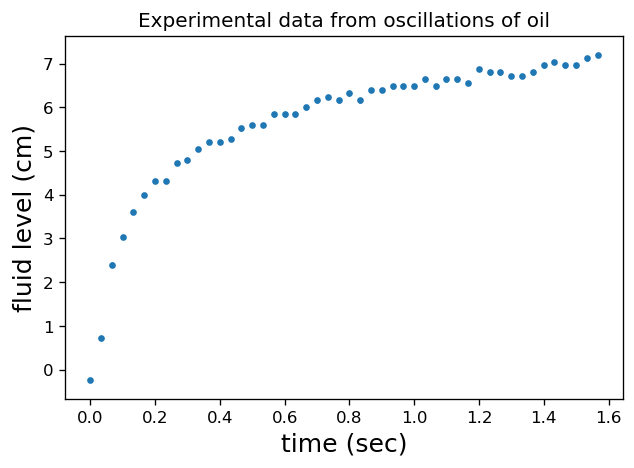

In [262]:
# user-modified area: Import data:
fluid = 'oil'
file_dir = './'
filename= f'{fluid}7cm.txt'

data = np.genfromtxt(filename,delimiter='\t',skip_header=2 )
time_data = data[:,0]
x_data = data[:,1]
z_data = data[:,1]*100 # in cm

timeshift = 0 # shifted so that t=0 is the time in video that the cap is released.

time_data_clean = time_data[np.isfinite(z_data)]-timeshift # cleaned data includes the timeshift, and removes any instances of infinite.

z_data_clean = z_data[np.isfinite(z_data)]
z_err = np.array([0.05]*len(z_data_clean))

z_data_clean = z_data_clean[7:] # clean out repeat points from oil
time_data_clean = time_data_clean[7:]
z_err = np.array([0.05]*len(z_data_clean))

# plot raw data
plt.errorbar(time_data_clean,z_data_clean, yerr=z_err, fmt='.')
plt.xlabel('time (sec)',fontsize=15)
plt.ylabel('fluid level (cm)',fontsize=15)
plt.title(f'Experimental data from oscillations of {fluid}')
plt.show()

In [264]:
z_data_clean = z_data_clean[1:]
time_data_clean = time_data_clean[1:]
z_err = z_err[1:]

271.53426251294644
-4.440892098500626e-16


/Users/kevinroice/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


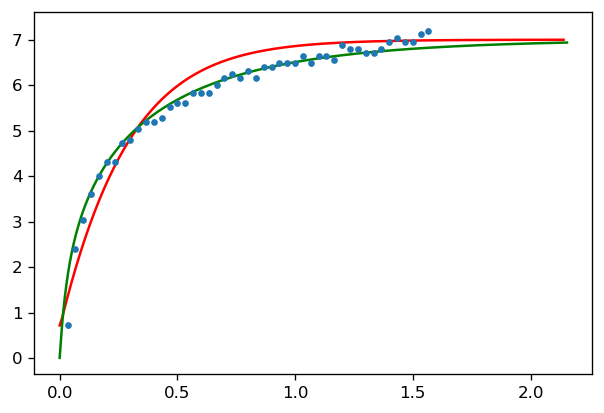

In [270]:
# Plot raw data
plt.errorbar(time_data_clean,z_data_clean, yerr=z_err, fmt='.')


# Newtonian Solution
g = 9.8*100
def DZdt_Newt(Z, t, h, b):
    return [Z[1], -Z[1]**2/Z[0] - g +g*h/Z[0] -b*Z[1]/Z[0]]

Z_intial = [z_data_clean[0], 0]
# Z_intial = [0.1, 0]
h=7
def Newt_solver(tsoln, b):
    return sp.integrate.odeint(DZdt_Newt, Z_intial, tsoln, args=(h,b))[:,0]



initial_values = np.array([1])
popt, pcov = optimize.curve_fit(Newt_solver, 
                        time_data_clean,
                        z_data_clean,
                        absolute_sigma=True, # Don't forget this!
                        p0=initial_values,
                        maxfev=500000)

b_solution = popt[0]

print(b_solution)
t_soln_Newt = np.arange(0, 2.15, 0.01)


z_soln_Newt = sp.integrate.odeint(DZdt_Newt, Z_intial, t_soln_Newt, args=(h,b_solution))[:,0]
plt.plot(t_soln_Newt,z_soln_Newt,'r',label='Newtonian model')

# Lorenceau Solution
def DZdt_Loren(Z, t, omega):
    if Z[1]>0:
        return [Z[1], 1/Z[0] - 1 -omega*Z[1] - (Z[1])**2/Z[0]]
    else:
        return [Z[1], 1/Z[0] - 1 -omega*Z[1] ]

def Lorenceau_solver(t, omega):
    return sp.integrate.odeint(DZdt_Loren, Z_intial, t, args=(omega,))[:,0]

Z_intial = [z_data_clean[0], 0]
initial_values = np.array([2])
popt, pcov = optimize.curve_fit(Lorenceau_solver, 
                        time_data_clean,
                        z_data_clean,
                        absolute_sigma=True, # Don't forget this!
                        p0=initial_values,
                        maxfev=5000)

omega_solution = popt[0]
t_soln_Lor = np.arange(0, 25.5, 0.01)
Z_intial = [0.001, 0]
print(omega_solution)
z_soln_Lor = sp.integrate.odeint(DZdt_Loren, Z_intial, t_soln_Lor, args=(7,))[:,0]*h
plt.plot(t_soln_Lor*(h*1e-2/9.8)**0.5,z_soln_Lor,'g',label='Lorenceau model')

Avergae interval between samples:  0.03332412049999999
Average sampling frequency:  30.00829384229361


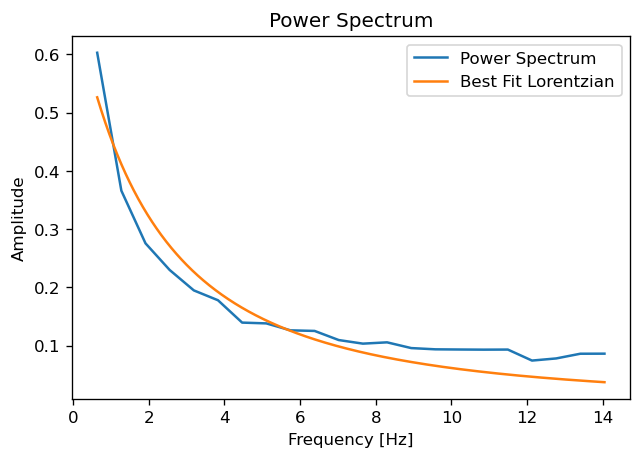

Peak of Lorentzian Profile = -4.24 Hz


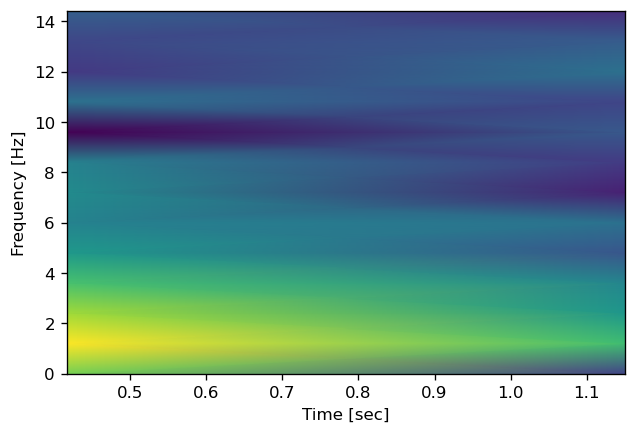

In [11]:
# FFT on raw data
# calculate avergae sampling rate
sum = 0
for i in range(len(time_data_clean)-1):
    sum += time_data_clean[i+1]-time_data_clean[i]


avg_time_between_samples = sum/(len(time_data_clean)-1)
print('Avergae interval between samples: ', avg_time_between_samples)

samplingFrequency   = 1/avg_time_between_samples
print('Average sampling frequency: ', samplingFrequency)

# Compute Fourier transform for Power Spectrum
# ignore t = 0
zs = z_data_clean[1:]
ts = time_data_clean[1:]

fourierTransform = np.fft.fft(zs)/len(zs)           # Normalize amplitude
fourierTransform = fourierTransform[range(int(len(zs)/2))] # Exclude sampling frequency

tpCount     = len(zs)
values      = np.arange(int(tpCount/2))
timePeriod  = tpCount/samplingFrequency
frequencies = values/timePeriod

# Frequency domain representation
# ignore peak at 0 Hz - this is caused by DC signal bias
# occurs when the signal encloses more area above the time axis than below
fourierTransform = fourierTransform[1:]
frequencies = frequencies[1:]

# Lorentzian profile to fit Power spectrum
def lorentzian(f, f0, A, gamma):
    return A * gamma**2 / (gamma**2 + (f-f0)**2)

initial_values = np.array([1, 1, 1])
popt, pcov = optimize.curve_fit(lorentzian, 
                        frequencies,
                        abs(fourierTransform),
                        absolute_sigma=True, # Don't forget this!
                        p0=initial_values,
                        maxfev=500000)

f0_solution, A_solution, gamma_solution = popt

f_peak_oil = f0_solution

smooth_fvals = np.linspace(min(frequencies), max(frequencies), 1000) 
smooth_lorentz = lorentzian(smooth_fvals, *popt)  

max_freq_component = frequencies[np.argmax(abs(fourierTransform))]


plt.title(f'Power Spectrum')
plt.plot(frequencies, abs(fourierTransform), label='Power Spectrum')
plt.plot(smooth_fvals, smooth_lorentz, label='Best Fit Lorentzian')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')

plt.legend()
plt.show()

print(f'Peak of Lorentzian Profile = {f0_solution:0.2f} Hz')

spec_cent = centroid(frequencies, abs(fourierTransform))

f, t, Sxx = signal.spectrogram(z_data_clean, samplingFrequency, nperseg=25)
plt.pcolormesh(t, f, np.log(Sxx), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

## Honey

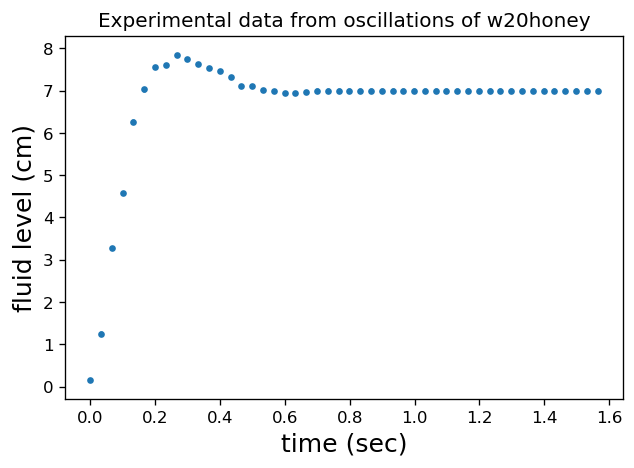

In [271]:
# user-modified area: Import data:
fluid = 'w20honey'
file_dir = './'
filename= f'{fluid}7cm.txt'

data = np.genfromtxt(filename,delimiter='\t',skip_header=2 )
time_data = data[:,0]
x_data = data[:,1]
z_data = data[:,1]*100 # in cm

timeshift = 0 # shifted so that t=0 is the time in video that the cap is released.

time_data_clean = time_data[np.isfinite(z_data)]-timeshift # cleaned data includes the timeshift, and removes any instances of infinite.

z_data_clean = z_data[np.isfinite(z_data)]
z_err = np.array([0.05]*len(z_data_clean))


z_err = np.array([0.05]*len(z_data_clean))

# z_data_clean = z_data_clean[:22]
# time_data_clean = time_data_clean[:22]
# z_err = z_err[:22]

# plot raw data
plt.errorbar(time_data_clean,z_data_clean, yerr=z_err, fmt='.')
plt.xlabel('time (sec)',fontsize=15)
plt.ylabel('fluid level (cm)',fontsize=15)
plt.title(f'Experimental data from oscillations of {fluid}')
plt.show()

58.30398307432384
-4.963000307173772


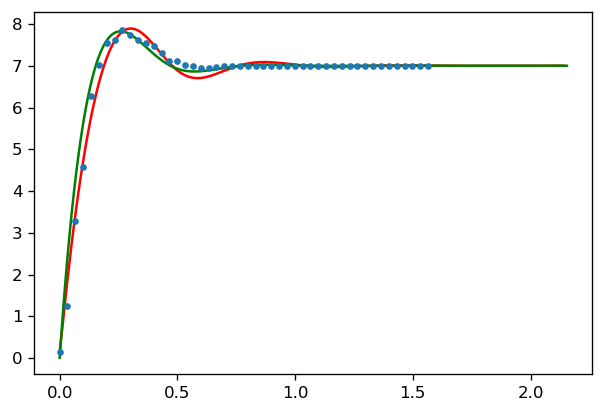

In [278]:
# Plot raw data
plt.errorbar(time_data_clean,z_data_clean, yerr=z_err, fmt='.')


# Newtonian Solution
g = 9.8*100
def DZdt_Newt(Z, t, h, b):
    return [Z[1], -Z[1]**2/Z[0] - g +g*h/Z[0] -b*Z[1]/Z[0]]

Z_intial = [z_data_clean[0], 0]
# Z_intial = [0.1, 0]
h=7
def Newt_solver(tsoln, b):
    return sp.integrate.odeint(DZdt_Newt, Z_intial, tsoln, args=(h,b))[:,0]



initial_values = np.array([1])
popt, pcov = optimize.curve_fit(Newt_solver, 
                        time_data_clean,
                        z_data_clean,
                        absolute_sigma=True, # Don't forget this!
                        p0=initial_values,
                        maxfev=500000)

b_solution = popt[0]

print(b_solution)
t_soln_Newt = np.arange(0, 2.15, 0.01)


z_soln_Newt = sp.integrate.odeint(DZdt_Newt, Z_intial, t_soln_Newt, args=(h,b_solution))[:,0]
plt.plot(t_soln_Newt,z_soln_Newt,'r',label='Newtonian model')

# Lorenceau Solution
def DZdt_Loren(Z, t, omega):
    if Z[1]>0:
        return [Z[1], 1/Z[0] - 1 -omega*Z[1] - (Z[1])**2/Z[0]]
    else:
        return [Z[1], 1/Z[0] - 1 -omega*Z[1] ]

def Lorenceau_solver(t, omega):
    return sp.integrate.odeint(DZdt_Loren, Z_intial, t, args=(omega,))[:,0]

Z_intial = [z_data_clean[0], 0]
initial_values = np.array([2])
popt, pcov = optimize.curve_fit(Lorenceau_solver, 
                        time_data_clean,
                        z_data_clean,
                        absolute_sigma=True, # Don't forget this!
                        p0=initial_values,
                        maxfev=5000)

omega_solution = popt[0]
t_soln_Lor = np.arange(0, 25.5, 0.01)
Z_intial = [0.001, 0]
print(omega_solution)
z_soln_Lor = sp.integrate.odeint(DZdt_Loren, Z_intial, t_soln_Lor, args=(0.95,))[:,0]*h
plt.plot(t_soln_Lor*(h*1e-2/9.8)**0.5,z_soln_Lor,'g',label='Lorenceau model')

Avergae interval between samples:  0.033284346276595746
Average sampling frequency:  30.044153239180815


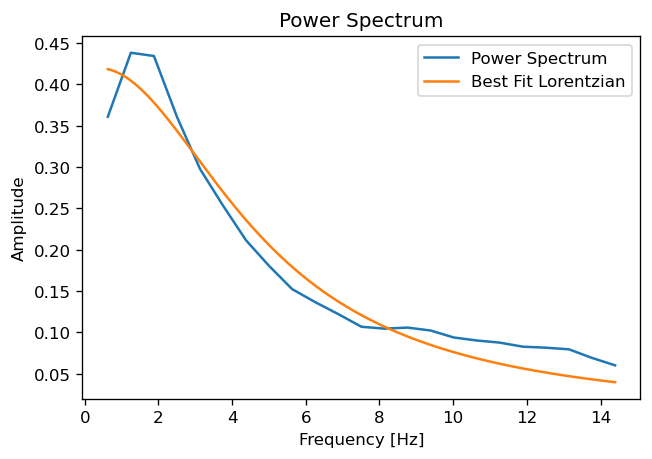

Peak of Lorentzian Profile = 0.37 Hz
FWHM = 9.09 Hz
Amplitude = 0.42


<ipython-input-279-42cb19151573>:69: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(t, f, np.log(Sxx), shading='gouraud')


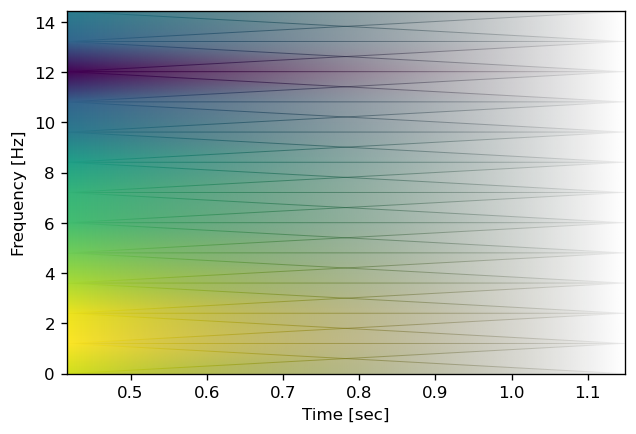

In [279]:
# FFT on raw data
# calculate avergae sampling rate
sum = 0
for i in range(len(time_data_clean)-1):
    sum += time_data_clean[i+1]-time_data_clean[i]


avg_time_between_samples = sum/(len(time_data_clean)-1)
print('Avergae interval between samples: ', avg_time_between_samples)

samplingFrequency   = 1/avg_time_between_samples
print('Average sampling frequency: ', samplingFrequency)

# Compute Fourier transform for Power Spectrum
# ignore t = 0
zs = z_data_clean
ts = time_data_clean

fourierTransform = np.fft.fft(zs)/len(zs)           # Normalize amplitude
fourierTransform = fourierTransform[range(int(len(zs)/2))] # Exclude sampling frequency

tpCount     = len(zs)
values      = np.arange(int(tpCount/2))
timePeriod  = tpCount/samplingFrequency
frequencies = values/timePeriod

# Frequency domain representation
# ignore peak at 0 Hz - this is caused by DC signal bias
# occurs when the signal encloses more area above the time axis than below
fourierTransform = fourierTransform[1:]
frequencies = frequencies[1:]

# Lorentzian profile to fit Power spectrum
def lorentzian(f, f0, A, gamma):
    return A * gamma**2 / (gamma**2 + (f-f0)**2)

initial_values = np.array([1, 1, 1])
popt, pcov = optimize.curve_fit(lorentzian, 
                        frequencies,
                        abs(fourierTransform),
                        absolute_sigma=True, # Don't forget this!
                        p0=initial_values,
                        maxfev=500000)

f0_solution, A_solution, gamma_solution = popt

smooth_fvals = np.linspace(min(frequencies), max(frequencies), 1000) 
smooth_lorentz = lorentzian(smooth_fvals, *popt)  

max_freq_component = frequencies[np.argmax(abs(fourierTransform))]


plt.title(f'Power Spectrum')
plt.plot(frequencies, abs(fourierTransform), label='Power Spectrum')
plt.plot(smooth_fvals, smooth_lorentz, label='Best Fit Lorentzian')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')

plt.legend()
plt.show()

print(f'Peak of Lorentzian Profile = {f0_solution:0.2f} Hz')
print(f'FWHM = {2*gamma_solution:0.2f} Hz')
print(f'Amplitude = {A_solution:0.2f}')

spec_cent = centroid(frequencies, abs(fourierTransform))

f, t, Sxx = signal.spectrogram(z_data_clean, samplingFrequency, nperseg=25)
plt.pcolormesh(t, f, np.log(Sxx), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

analysisng honey after removing non-socillaotry motion

---

## Temperature Variation

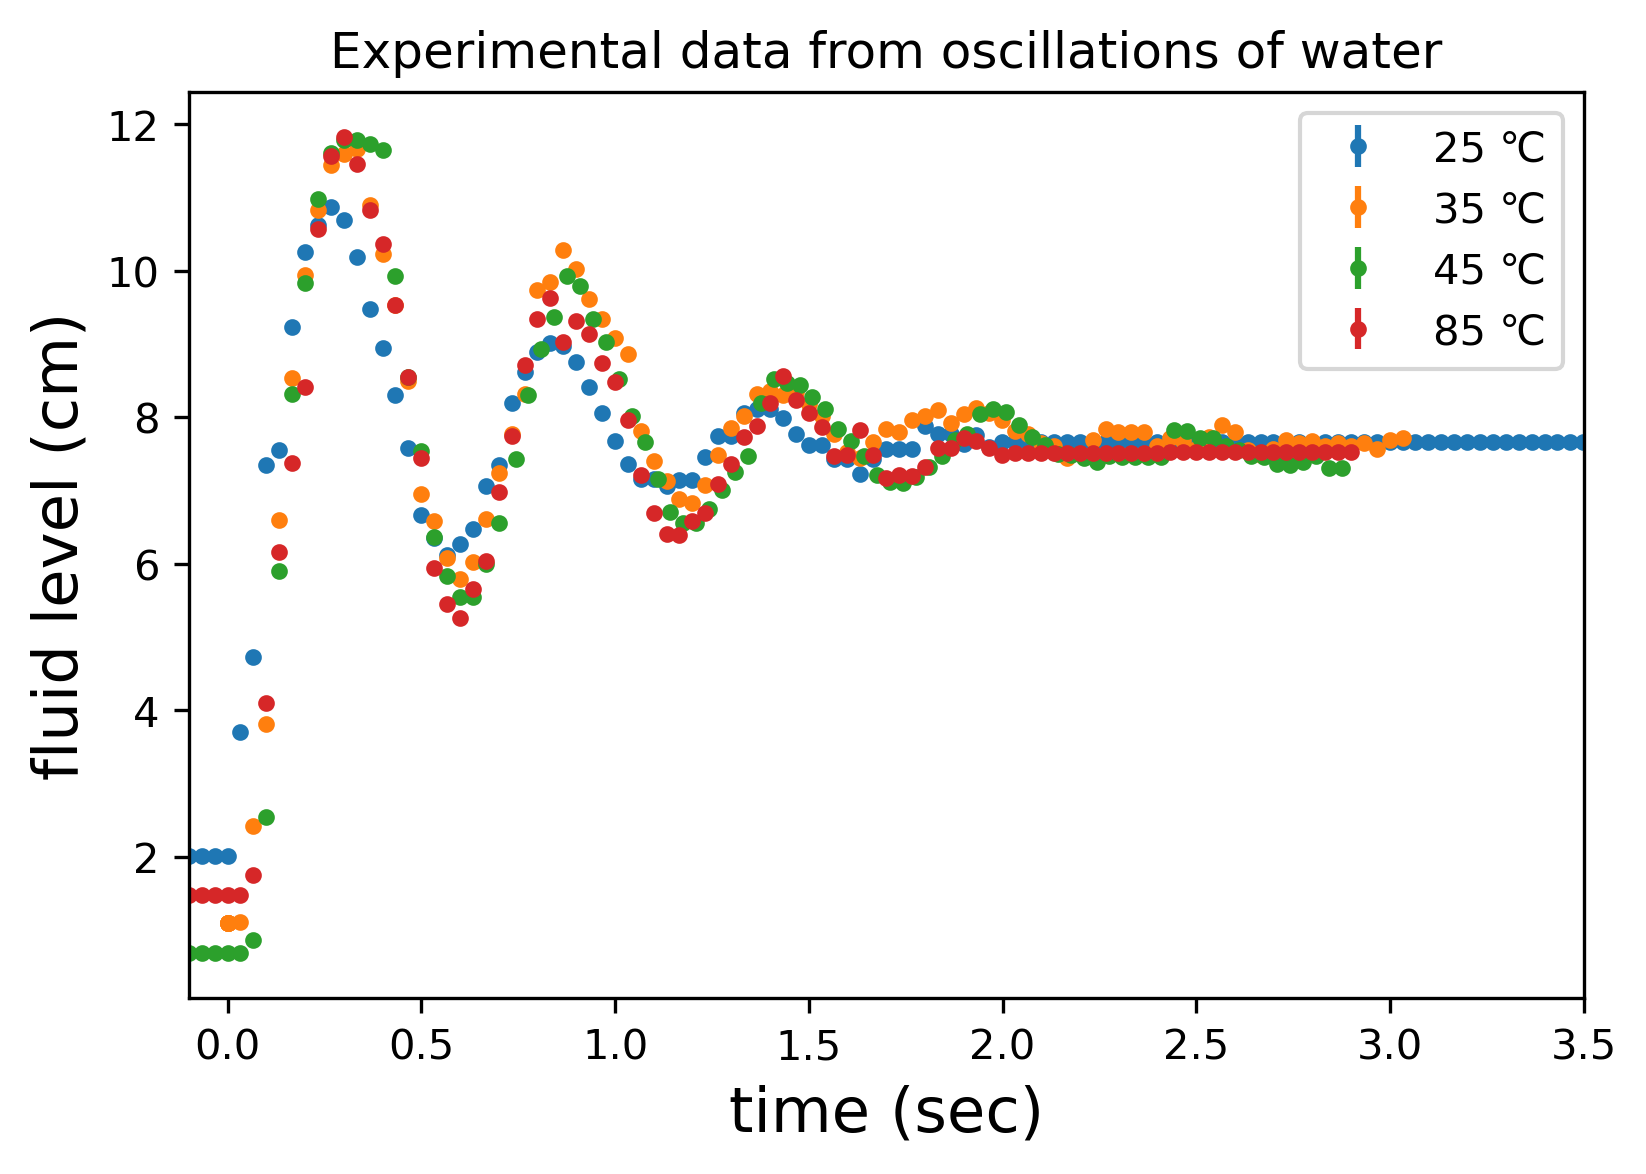

In [342]:
# user-modified area: Import data:
temp = '25,9'
file_dir = './'
filename= f'water7cm_{temp}deg.txt'
data = np.genfromtxt(filename,delimiter='\t',skip_header=2 )
time_data = data[:,0]
z_data = data[:,2]*100 # in cm
timeshift = 0.6330777777777779 # shifted so that t=0 is the time in video that the cap is released.
time_data_clean_25 = time_data[np.isfinite(z_data)]-timeshift # cleaned data includes the timeshift, and removes any instances of infinite.
z_data_clean_25 = z_data[np.isfinite(z_data)]
z_err = np.array([0.05]*len(z_data_clean_25))
plt.errorbar(time_data_clean_25,z_data_clean_25, yerr=z_err, fmt='.', label='25 ℃')

temp = '36,0'
file_dir = './'
filename= f'water7cm_{temp}deg.txt'
data = np.genfromtxt(filename,delimiter='\t',skip_header=2 )
time_data = data[:,0]
z_data = data[:,1]*100 # in cm
timeshift = 0 # shifted so that t=0 is the time in video that the cap is released.
time_data_clean_35 = time_data[np.isfinite(z_data)]-timeshift # cleaned data includes the timeshift, and removes any instances of infinite.
z_data_clean_35 = z_data[np.isfinite(z_data)]
z_err = np.array([0.05]*len(z_data_clean_35))
plt.errorbar(time_data_clean_35,z_data_clean_35, yerr=z_err, fmt='.', label='35 ℃')

temp = '44,6'
file_dir = './'
filename= f'water7cm_{temp}deg.txt'
data = np.genfromtxt(filename,delimiter='\t',skip_header=2 )
time_data = data[:,0]
z_data = data[:,2]*100 # in cm
timeshift = 0.43315555555555557 # shifted so that t=0 is the time in video that the cap is released.
time_data_clean_45 = time_data[np.isfinite(z_data)]-timeshift # cleaned data includes the timeshift, and removes any instances of infinite.
z_data_clean_45 = z_data[np.isfinite(z_data)]
z_err = np.array([0.05]*len(z_data_clean_45))
plt.errorbar(time_data_clean_45,z_data_clean_45, yerr=z_err, fmt='.', label='45 ℃')

temp = '85'
file_dir = './'
filename= f'water7cm_{temp}deg.txt'
data = np.genfromtxt(filename,delimiter='\t',skip_header=2 )
time_data = data[:,0]
z_data = data[:,2]*100 # in cm
timeshift = 2.132477777777778 # shifted so that t=0 is the time in video that the cap is released.
time_data_clean_85 = time_data[np.isfinite(z_data)]-timeshift # cleaned data includes the timeshift, and removes any instances of infinite.
z_data_clean_85 = z_data[np.isfinite(z_data)]
z_err = np.array([0.05]*len(z_data_clean_85))
plt.errorbar(time_data_clean_85,z_data_clean_85, yerr=z_err, fmt='.', label='85 ℃')




plt.xlabel('time (sec)',fontsize=15)
plt.ylabel('fluid level (cm)',fontsize=15)
plt.xlim((-0.1, 3.5))
plt.title(f'Experimental data from oscillations of {fluid}')
plt.legend()
plt.show()

For frequency analysis, we want to start at 0 but just look at the oscillatory motion.

In [48]:
z_data_clean_25 = z_data_clean_25[19:-72]
z_data_clean_35 = z_data_clean_35[7:]
z_data_clean_45 = z_data_clean_45[14:]
z_data_clean_85 = z_data_clean_85[65:-26]
time_data_clean_25 = time_data_clean_25[19:-72]
time_data_clean_35 = time_data_clean_35[7:]
time_data_clean_45 = time_data_clean_45[14:]
time_data_clean_85 = time_data_clean_85[65:-26]

OR just have them all start from the jump

In [343]:
z_data_clean_25 = z_data_clean_25[19:]
z_data_clean_35 = z_data_clean_35[7:]
z_data_clean_45 = z_data_clean_45[14:]
z_data_clean_85 = z_data_clean_85[65:]
time_data_clean_25 = time_data_clean_25[19:]
time_data_clean_35 = time_data_clean_35[7:]
time_data_clean_45 = time_data_clean_45[14:]
time_data_clean_85 = time_data_clean_85[65:]


OR just sinusoidal moion:

In [72]:
z_data_clean_25 = z_data_clean_25[23:-72]
z_data_clean_35 = z_data_clean_35[12:]
z_data_clean_45 = z_data_clean_45[18:]
z_data_clean_85 = z_data_clean_85[69:-26]

time_data_clean_25 = time_data_clean_25[23:-72]
time_data_clean_35 = time_data_clean_35[12:]
time_data_clean_45 = time_data_clean_45[18:]
time_data_clean_85 = time_data_clean_85[69:-26]



2.0095314184661928
1.0994569920000001
0.6847255066157409
1.4832279860172966


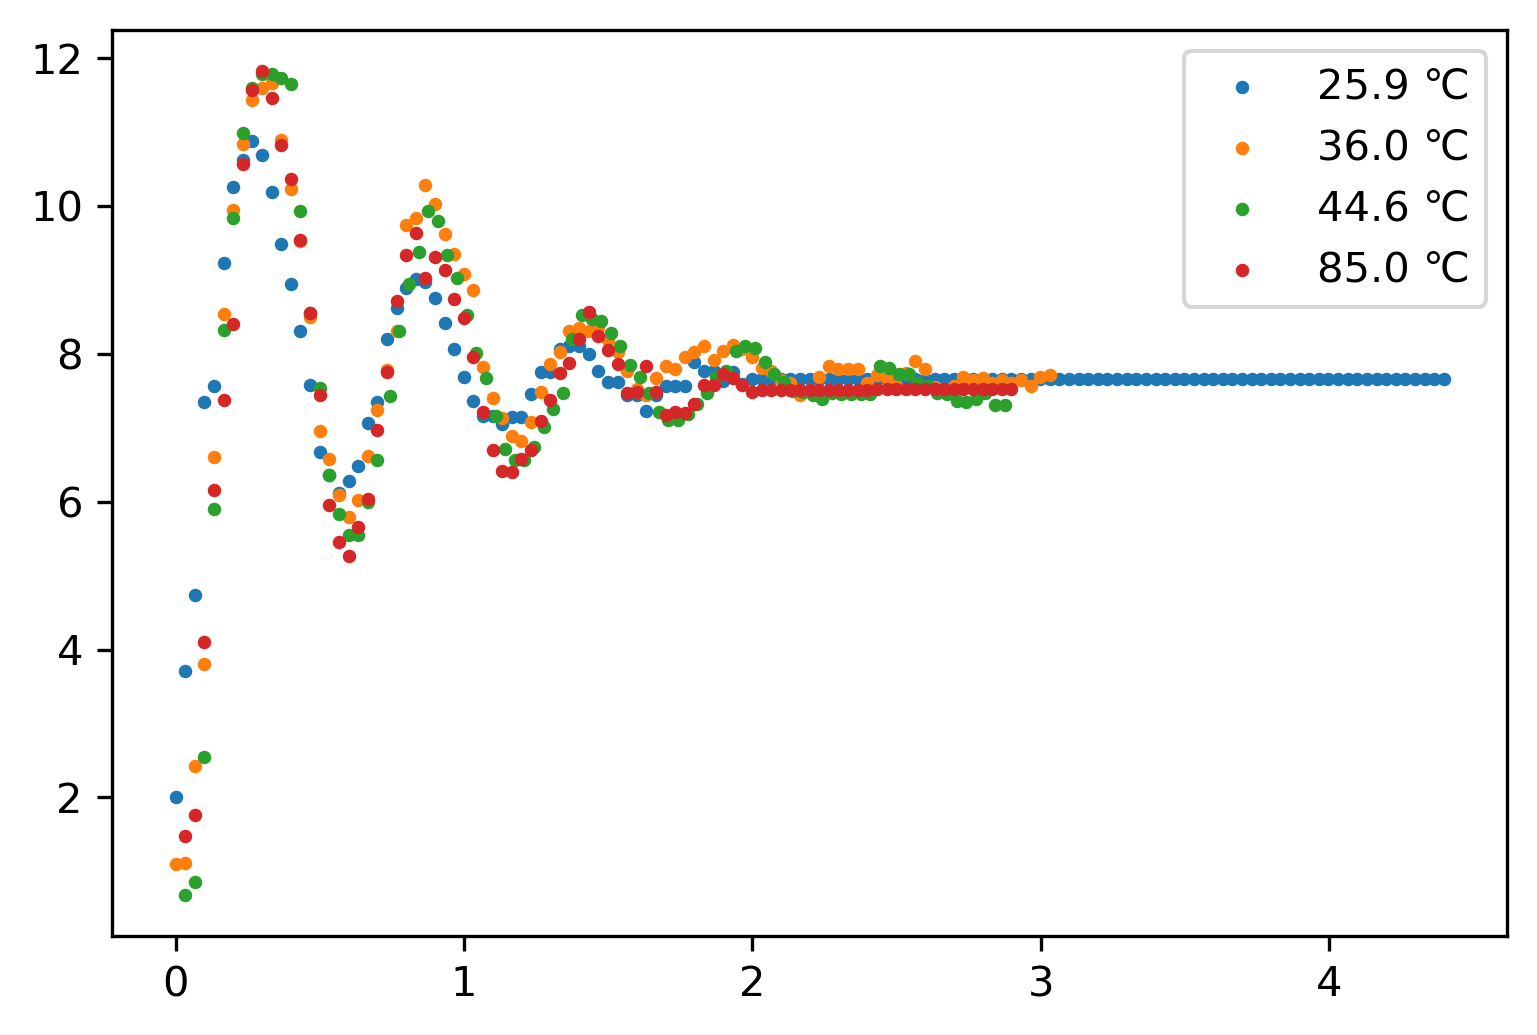

In [345]:
plt.scatter(time_data_clean_25,z_data_clean_25, label='25.9 ℃', s=5)
plt.scatter(time_data_clean_35,z_data_clean_35, label='36.0 ℃', s=5)
plt.scatter(time_data_clean_45,z_data_clean_45, label='44.6 ℃', s=5)
plt.scatter(time_data_clean_85,z_data_clean_85, label='85.0 ℃', s=5)
plt.legend()

print(z_data_clean_25[0])
print(z_data_clean_35[0])
print(z_data_clean_45[0])
print(z_data_clean_85[0])

Newtonian solutions:

[14.60422483]
minimised chi-squared for 25 deg = 8646.466803877398
reduced chi^2 for Newton at 25 degrees = 100.540311672993
[16.42100929]
minimised chi-squared for 25 deg = 5219.277776076102
reduced chi^2 for Newton at 25 degrees = 39.53998315209168
[13.]
minimised chi-squared for 35 deg = 30957.486883888374
reduced chi^2 for Newton at 35 degrees = 340.19216355921293
[17.00928552]
minimised chi-squared for 45 deg = 14866.411917545249
reduced chi^2 for Newton at 45 degrees = 174.89896373582647
[11.16348978]
minimised chi-squared for 85 deg = 14215.026818855624
reduced chi^2 for Newton at 85 degrees = 165.29100952157702


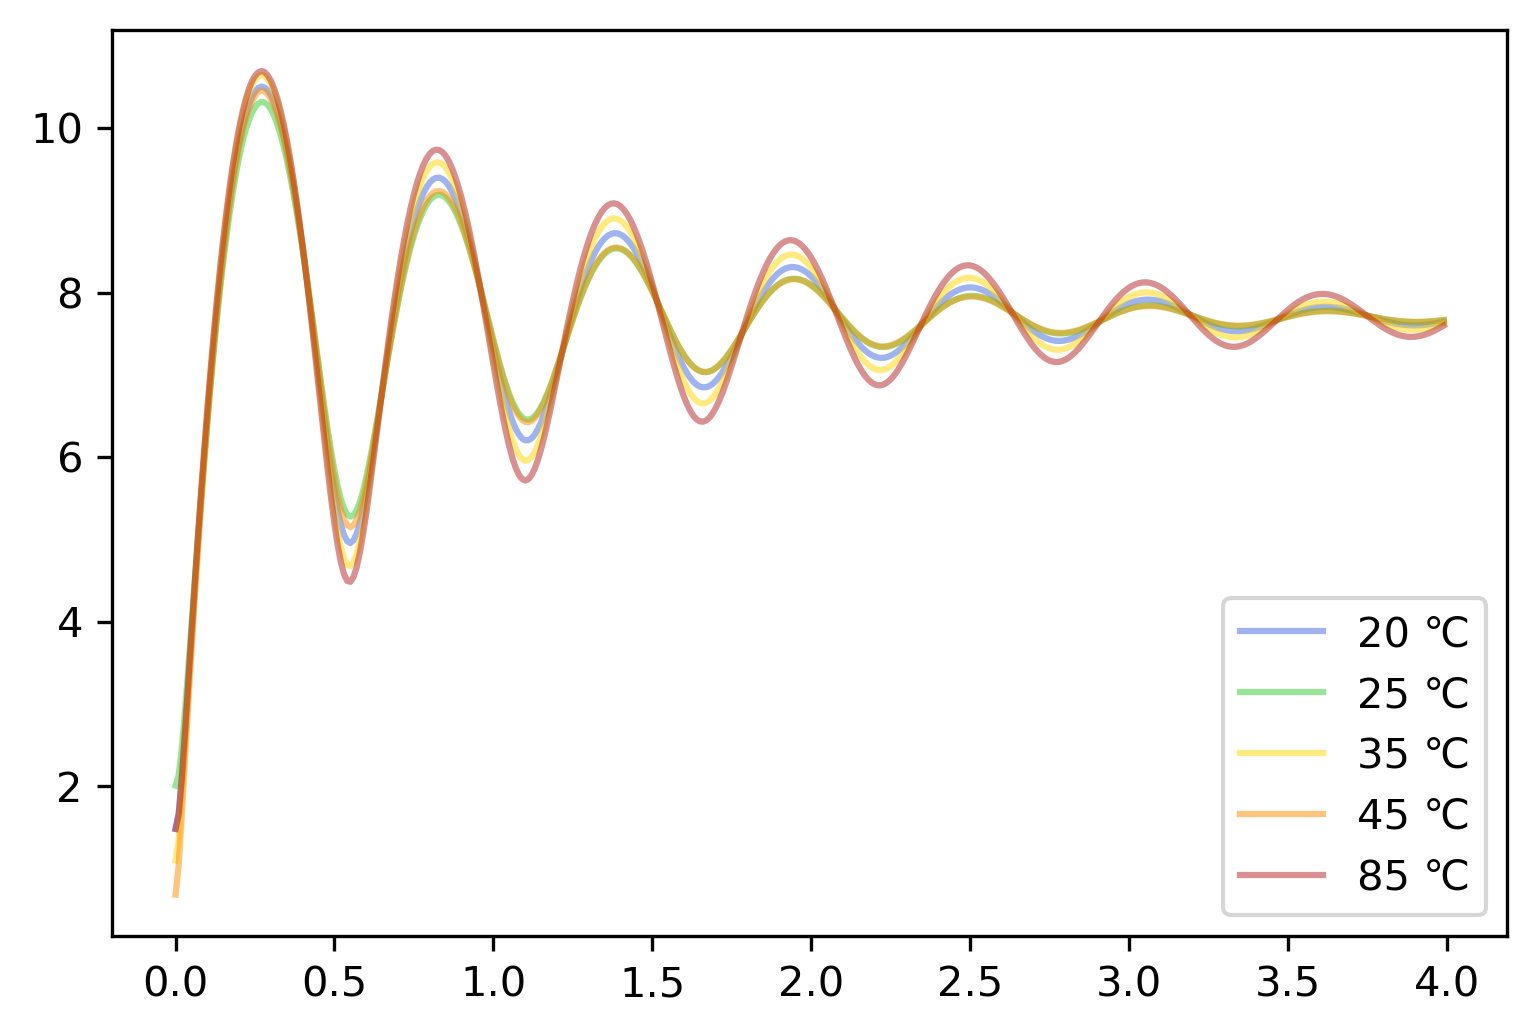

In [392]:
# Plot raw data


# Newtonian Solution
g = 9.8*100
def DZdt_Newt(Z, t, h, b):
    return [Z[1], -Z[1]**2/Z[0] - g +g*h/Z[0] -b*Z[1]/Z[0]]

# 20 degrees, use same data as first cell in this notebook

Z_intial = [z_data_clean[0], 0]
# Z_intial = [0.1, 0]
h=7.7
def Newt_solver(tsoln, b):
    return sp.integrate.odeint(DZdt_Newt, Z_intial, tsoln, args=(h,b))[:,0]



initial_values = np.array([13])
time_data_clean = time_data_clean.astype(dtype=np.float32)
z_data_clean = z_data_clean.astype(dtype=np.float32)
popt, pcov = optimize.curve_fit(Newt_solver, 
                        time_data_clean,
                        z_data_clean,
                        absolute_sigma=True, # Don't forget this!
                        p0=initial_values,
                        maxfev=500000)

b_solution = popt[0]

print(popt)
# b_solution = 13
t_soln_Newt = np.arange(0, 4, 0.01)


z_soln_Newt = sp.integrate.odeint(DZdt_Newt, Z_intial, t_soln_Newt, args=(h,b_solution))[:,0]

# res_calc_Newt = sp.integrate.odeint(DZdt_Newt, Z_intial, time_data_clean, args=(h,b_solution))[:,0]
# res_Newton = (z_data_clean - res_calc_Newt)/z_err
chisq_min = chi_squared([b_solution], # pass the array - no need to unpack
                        Newt_solver, 
                        time_data_clean, 
                        z_data_clean, 
                        z_err)
print('minimised chi-squared for 25 deg = {}'.format(chisq_min))
deg_freedom = z_data_clean.size - initial_values.size # Make sure you understand why!
chisq_reduced = chisq_min/deg_freedom
print('reduced chi^2 for Newton at 25 degrees = {}'.format(chisq_reduced))
plt.plot(t_soln_Newt,z_soln_Newt,'royalblue',label='20 ℃', alpha = 0.5)

#

z_data_clean = z_data_clean_25
time_data_clean = time_data_clean_25
z_err = np.array([0.05]*len(z_data_clean))

Z_intial = [z_data_clean[0], 0]
# Z_intial = [0.1, 0]
h=7.7
def Newt_solver(tsoln, b):
    return sp.integrate.odeint(DZdt_Newt, Z_intial, tsoln, args=(h,b))[:,0]



initial_values = np.array([13])
time_data_clean = time_data_clean.astype(dtype=np.float32)
z_data_clean = z_data_clean.astype(dtype=np.float32)
popt, pcov = optimize.curve_fit(Newt_solver, 
                        time_data_clean,
                        z_data_clean,
                        absolute_sigma=True, # Don't forget this!
                        p0=initial_values,
                        maxfev=500000)

b_solution = popt[0]

print(popt)
# b_solution = 13
t_soln_Newt = np.arange(0, 4, 0.01)


z_soln_Newt = sp.integrate.odeint(DZdt_Newt, Z_intial, t_soln_Newt, args=(h,b_solution))[:,0]

# res_calc_Newt = sp.integrate.odeint(DZdt_Newt, Z_intial, time_data_clean, args=(h,b_solution))[:,0]
# res_Newton = (z_data_clean - res_calc_Newt)/z_err
chisq_min = chi_squared([b_solution], # pass the array - no need to unpack
                        Newt_solver, 
                        time_data_clean, 
                        z_data_clean, 
                        z_err)
print('minimised chi-squared for 25 deg = {}'.format(chisq_min))
deg_freedom = z_data_clean.size - initial_values.size # Make sure you understand why!
chisq_reduced = chisq_min/deg_freedom
print('reduced chi^2 for Newton at 25 degrees = {}'.format(chisq_reduced))
plt.plot(t_soln_Newt,z_soln_Newt,'limegreen',label='25 ℃', alpha = 0.5)

#

z_data_clean = z_data_clean_35
time_data_clean = time_data_clean_35
z_err = np.array([0.05]*len(z_data_clean))
Z_intial = [z_data_clean[0], 0]

initial_values = np.array([13])
time_data_clean = time_data_clean.astype(dtype=np.float64)
z_data_clean = z_data_clean.astype(dtype=np.float64)
popt, pcov = optimize.curve_fit(Newt_solver, 
                        time_data_clean,
                        z_data_clean,
                        absolute_sigma=True, # Don't forget this!
                        p0=initial_values,
                        maxfev=500000)

b_solution = popt[0]

print(popt)
b_solution = 13
t_soln_Newt = np.arange(0, 4, 0.01)


z_soln_Newt = sp.integrate.odeint(DZdt_Newt, Z_intial, t_soln_Newt, args=(h,b_solution))[:,0]

# res_calc_Newt = sp.integrate.odeint(DZdt_Newt, Z_intial, time_data_clean, args=(h,b_solution))[:,0]
# res_Newton = (z_data_clean - res_calc_Newt)/z_err
chisq_min = chi_squared([b_solution], # pass the array - no need to unpack
                        Newt_solver, 
                        time_data_clean, 
                        z_data_clean, 
                        z_err)
print('minimised chi-squared for 35 deg = {}'.format(chisq_min))
deg_freedom = z_data_clean.size - initial_values.size # Make sure you understand why!
chisq_reduced = chisq_min/deg_freedom
print('reduced chi^2 for Newton at 35 degrees = {}'.format(chisq_reduced))
plt.plot(t_soln_Newt,z_soln_Newt,'gold',label='35 ℃', alpha = 0.5)

#

z_data_clean = z_data_clean_45
time_data_clean = time_data_clean_45
z_err = np.array([0.05]*len(z_data_clean))
Z_intial = [z_data_clean[0], 0]

initial_values = np.array([13])
time_data_clean = time_data_clean.astype(dtype=np.float64)
z_data_clean = z_data_clean.astype(dtype=np.float64)
popt, pcov = optimize.curve_fit(Newt_solver, 
                        time_data_clean,
                        z_data_clean,
                        absolute_sigma=True, # Don't forget this!
                        p0=initial_values,
                        maxfev=500000)

b_solution = popt[0]

print(popt)
b_solution = 17
t_soln_Newt = np.arange(0, 4, 0.01)


z_soln_Newt = sp.integrate.odeint(DZdt_Newt, Z_intial, t_soln_Newt, args=(h,b_solution))[:,0]

# res_calc_Newt = sp.integrate.odeint(DZdt_Newt, Z_intial, time_data_clean, args=(h,b_solution))[:,0]
# res_Newton = (z_data_clean - res_calc_Newt)/z_err
chisq_min = chi_squared([b_solution], # pass the array - no need to unpack
                        Newt_solver, 
                        time_data_clean, 
                        z_data_clean, 
                        z_err)
print('minimised chi-squared for 45 deg = {}'.format(chisq_min))
deg_freedom = z_data_clean.size - initial_values.size # Make sure you understand why!
chisq_reduced = chisq_min/deg_freedom
print('reduced chi^2 for Newton at 45 degrees = {}'.format(chisq_reduced))
plt.plot(t_soln_Newt,z_soln_Newt,'darkorange',label='45 ℃', alpha = 0.5)


#

z_data_clean = z_data_clean_85
time_data_clean = time_data_clean_85
z_err = np.array([0.05]*len(z_data_clean))
# plt.errorbar(time_data_clean,z_data_clean, yerr=z_err, fmt='.')
Z_intial = [z_data_clean[0], 0]

initial_values = np.array([10])
time_data_clean = time_data_clean.astype(dtype=np.float32)
z_data_clean = z_data_clean.astype(dtype=np.float32)
popt, pcov = optimize.curve_fit(Newt_solver, 
                        time_data_clean,
                        z_data_clean,
                        absolute_sigma=True, # Don't forget this!
                        p0=initial_values,
                        maxfev=500000)

b_solution = popt[0]

print(popt)
b_solution = 11.2
t_soln_Newt = np.arange(0, 4, 0.01)


z_soln_Newt = sp.integrate.odeint(DZdt_Newt, Z_intial, t_soln_Newt, args=(h,b_solution))[:,0]

# res_calc_Newt = sp.integrate.odeint(DZdt_Newt, Z_intial, time_data_clean, args=(h,b_solution))[:,0]
# res_Newton = (z_data_clean - res_calc_Newt)/z_err
chisq_min = chi_squared([b_solution], # pass the array - no need to unpack
                        Newt_solver, 
                        time_data_clean, 
                        z_data_clean, 
                        z_err)
print('minimised chi-squared for 85 deg = {}'.format(chisq_min))
deg_freedom = z_data_clean.size - initial_values.size # Make sure you understand why!
chisq_reduced = chisq_min/deg_freedom
print('reduced chi^2 for Newton at 85 degrees = {}'.format(chisq_reduced))
plt.plot(t_soln_Newt,z_soln_Newt,'firebrick',label='85 ℃', alpha = 0.5)
plt.legend()


1.5330737800569572


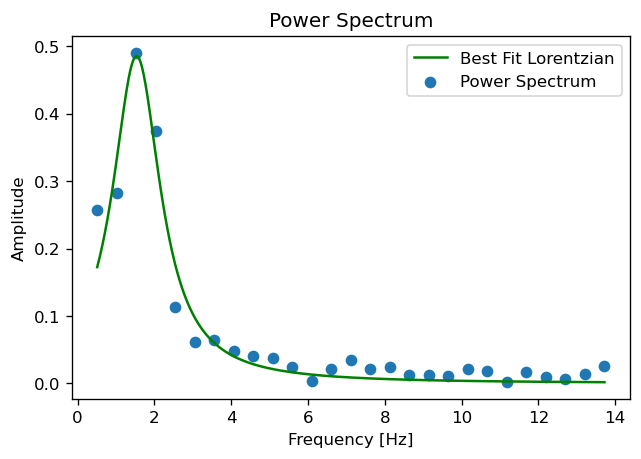

Peak of Lorentzian Profile = 1.53 Hz
FWHM = 1.52 Hz
Amplitude = 0.49


In [74]:
zs = z_data_clean_25
ts = time_data_clean_25

fourierTransform = np.fft.fft(zs)/len(zs)           # Normalize amplitude
fourierTransform = fourierTransform[range(int(len(zs)/2))] # Exclude sampling frequency

tpCount     = len(zs)
values      = np.arange(int(tpCount/2))
timePeriod  = tpCount/samplingFrequency
frequencies = values/timePeriod

# Frequency domain representation
# ignore peak at 0 Hz - this is caused by DC signal bias
# occurs when the signal encloses more area above the time axis than below
fourierTransform = fourierTransform[1:]
frequencies = frequencies[1:]

initial_values = np.array([1, 1, 1])
popt, pcov = optimize.curve_fit(lorentzian, 
                        frequencies,
                        abs(fourierTransform),
                        absolute_sigma=True, # Don't forget this!
                        p0=initial_values,
                        maxfev=500000)

f0_solution, A_solution, gamma_solution = popt
print(f0_solution)
fp_w25 = f0_solution
fwhm_w25 = 2*gamma_solution

smooth_fvals = np.linspace(min(frequencies), max(frequencies), 1000) 
smooth_lorentz = lorentzian(smooth_fvals, *popt)  

max_freq_component = frequencies[np.argmax(abs(fourierTransform))]


plt.title(f'Power Spectrum')
plt.scatter(frequencies, abs(fourierTransform), label='Power Spectrum')
plt.plot(smooth_fvals, smooth_lorentz, label='Best Fit Lorentzian', color='g')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')

plt.legend()
plt.show()
print(f'Peak of Lorentzian Profile = {f0_solution:0.2f} Hz')
print(f'FWHM = {2*gamma_solution:0.2f} Hz')
print(f'Amplitude = {A_solution:0.2f}')

1.5512075866042403


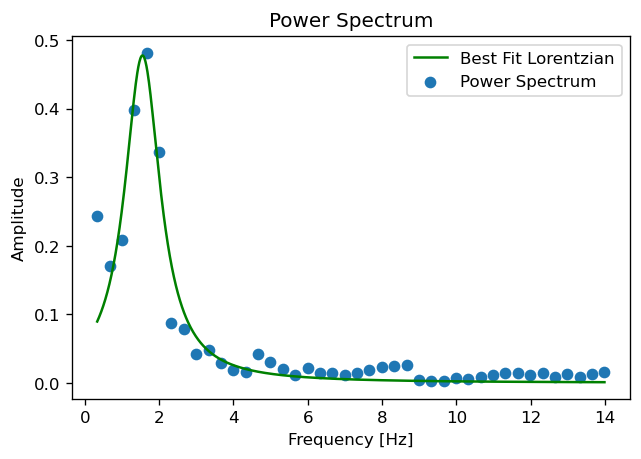

Peak of Lorentzian Profile = 1.55 Hz
FWHM = 1.17 Hz
Amplitude = 0.48


In [75]:
zs = z_data_clean_35
ts = time_data_clean_35

fourierTransform = np.fft.fft(zs)/len(zs)           # Normalize amplitude
fourierTransform = fourierTransform[range(int(len(zs)/2))] # Exclude sampling frequency

tpCount     = len(zs)
values      = np.arange(int(tpCount/2))
timePeriod  = tpCount/samplingFrequency
frequencies = values/timePeriod

# Frequency domain representation
# ignore peak at 0 Hz - this is caused by DC signal bias
# occurs when the signal encloses more area above the time axis than below
fourierTransform = fourierTransform[1:]
frequencies = frequencies[1:]

initial_values = np.array([1, 1, 1])
popt, pcov = optimize.curve_fit(lorentzian, 
                        frequencies,
                        abs(fourierTransform),
                        absolute_sigma=True, # Don't forget this!
                        p0=initial_values,
                        maxfev=500000)

f0_solution, A_solution, gamma_solution = popt
print(f0_solution)
fp_w35 = f0_solution
fwhm_w35 = 2*gamma_solution

smooth_fvals = np.linspace(min(frequencies), max(frequencies), 1000) 
smooth_lorentz = lorentzian(smooth_fvals, *popt)  

max_freq_component = frequencies[np.argmax(abs(fourierTransform))]


plt.title(f'Power Spectrum')
plt.scatter(frequencies, abs(fourierTransform), label='Power Spectrum')
plt.plot(smooth_fvals, smooth_lorentz, label='Best Fit Lorentzian', color='g')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')

plt.legend()
plt.show()
print(f'Peak of Lorentzian Profile = {f0_solution:0.2f} Hz')
print(f'FWHM = {2*gamma_solution:0.2f} Hz')
print(f'Amplitude = {A_solution:0.2f}')

1.576370961576949


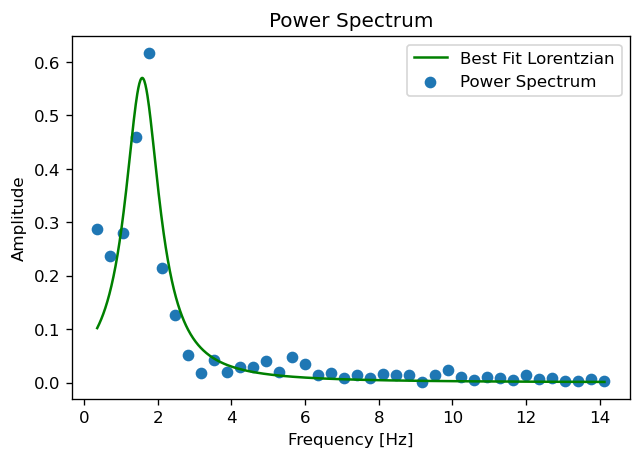

Peak of Lorentzian Profile = 1.58 Hz
FWHM = 1.14 Hz
Amplitude = 0.57


In [76]:
zs = z_data_clean_45
ts = time_data_clean_45

fourierTransform = np.fft.fft(zs)/len(zs)           # Normalize amplitude
fourierTransform = fourierTransform[range(int(len(zs)/2))] # Exclude sampling frequency

tpCount     = len(zs)
values      = np.arange(int(tpCount/2))
timePeriod  = tpCount/samplingFrequency
frequencies = values/timePeriod

# Frequency domain representation
# ignore peak at 0 Hz - this is caused by DC signal bias
# occurs when the signal encloses more area above the time axis than below
fourierTransform = fourierTransform[1:]
frequencies = frequencies[1:]

initial_values = np.array([1, 1, 1])
popt, pcov = optimize.curve_fit(lorentzian, 
                        frequencies,
                        abs(fourierTransform),
                        absolute_sigma=True, # Don't forget this!
                        p0=initial_values,
                        maxfev=500000)

f0_solution, A_solution, gamma_solution = popt
print(f0_solution)
fp_w45 = f0_solution
fwhm_w45 = 2*gamma_solution

smooth_fvals = np.linspace(min(frequencies), max(frequencies), 1000) 
smooth_lorentz = lorentzian(smooth_fvals, *popt)  

max_freq_component = frequencies[np.argmax(abs(fourierTransform))]


plt.title(f'Power Spectrum')
plt.scatter(frequencies, abs(fourierTransform), label='Power Spectrum')
plt.plot(smooth_fvals, smooth_lorentz, label='Best Fit Lorentzian', color='g')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')

plt.legend()
plt.show()
print(f'Peak of Lorentzian Profile = {f0_solution:0.2f} Hz')
print(f'FWHM = {2*gamma_solution:0.2f} Hz')
print(f'Amplitude = {A_solution:0.2f}')

1.626778927827576


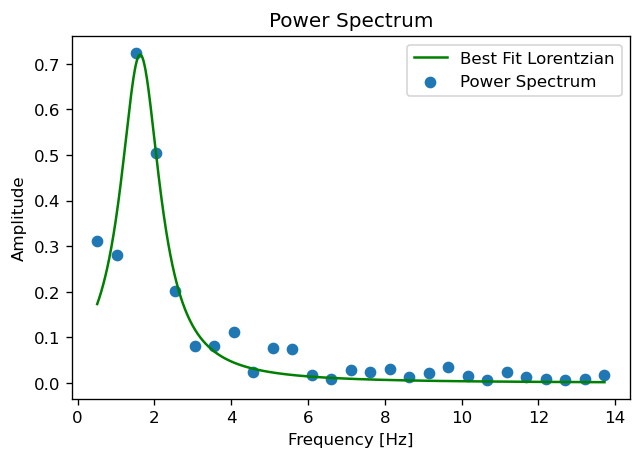

Peak of Lorentzian Profile = 1.63 Hz
FWHM = 1.26 Hz
Amplitude = 0.72


In [77]:
zs = z_data_clean_85
ts = time_data_clean_85

fourierTransform = np.fft.fft(zs)/len(zs)           # Normalize amplitude
fourierTransform = fourierTransform[range(int(len(zs)/2))] # Exclude sampling frequency

tpCount     = len(zs)
values      = np.arange(int(tpCount/2))
timePeriod  = tpCount/samplingFrequency
frequencies = values/timePeriod

# Frequency domain representation
# ignore peak at 0 Hz - this is caused by DC signal bias
# occurs when the signal encloses more area above the time axis than below
fourierTransform = fourierTransform[1:]
frequencies = frequencies[1:]

initial_values = np.array([1, 1, 1])
popt, pcov = optimize.curve_fit(lorentzian, 
                        frequencies,
                        abs(fourierTransform),
                        absolute_sigma=True, # Don't forget this!
                        p0=initial_values,
                        maxfev=500000)

f0_solution, A_solution, gamma_solution = popt
print(f0_solution)
fp_w85 = f0_solution
fwhm_w85 = 2*gamma_solution

smooth_fvals = np.linspace(min(frequencies), max(frequencies), 1000) 
smooth_lorentz = lorentzian(smooth_fvals, *popt)  

max_freq_component = frequencies[np.argmax(abs(fourierTransform))]


plt.title(f'Power Spectrum')
plt.scatter(frequencies, abs(fourierTransform), label='Power Spectrum')
plt.plot(smooth_fvals, smooth_lorentz, label='Best Fit Lorentzian', color='g')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')

plt.legend()
plt.show()
print(f'Peak of Lorentzian Profile = {f0_solution:0.2f} Hz')
print(f'FWHM = {2*gamma_solution:0.2f} Hz')
print(f'Amplitude = {A_solution:0.2f}')

---

# Variation with Viscosity

Water viscosity values were looked up from ([Korson et al., 1968](https://d1wqtxts1xzle7.cloudfront.net/45788374/Viscosity_of_Water_at_Various_Temperatur20160519-32250-rbas1z-with-cover-page-v2.pdf?Expires=1647970352&Signature=a~-TXpVaxtm~lycIjawyDbcjkI-qytbumFGWoNlCGcbWgCnEgriFE11~XCX~1VBfoqEXGCsHqpuF17HIHqpQiQ7yWqVxfxhOgRW5kD2WGfW2X7pJ5iRz06vGwaXJXzdM9Bq2M7dZODB4zdJZKdeIIfqkrzjDqU0bL4ycQIXF4QPEuy-~k~OTTNJ5WXvQBcAz1n~HEmKRtbfhvYC3iGWoyIhY44cPDD28aIRwJjUNUFm8bXXpYbSLFDZAHkaVkr60duwA2OK60PvK~phtpsN8azFhUJvfy4TmuAndXLp0m~XyBkBVQGOwURmxXeuGthlaKKJi78ib1-PrdqJ-WgA7JA__&Key-Pair-Id=APKAJLOHF5GGSLRBV4ZA))

Thisis what you get when you analyse from z=0 t=0

In [55]:
names = ['w20', 'w25', 'w35', 'w45', 'w85', 'm', 'h'] # in degrees C
mus_nearest = [1.0020, 0.8903, 0.7195, 0.5963, 0.3323, 1.79] # in mPas
mus_LinearInterpolation = []
f_peaks = [fp_w20, fp_w25, fp_w35, fp_w45, fp_w85, fp_milk]
fwhms = [fwhm_w20, fwhm_w25, fwhm_w35, fwhm_w45, fwhm_w85, fwhm_milk]


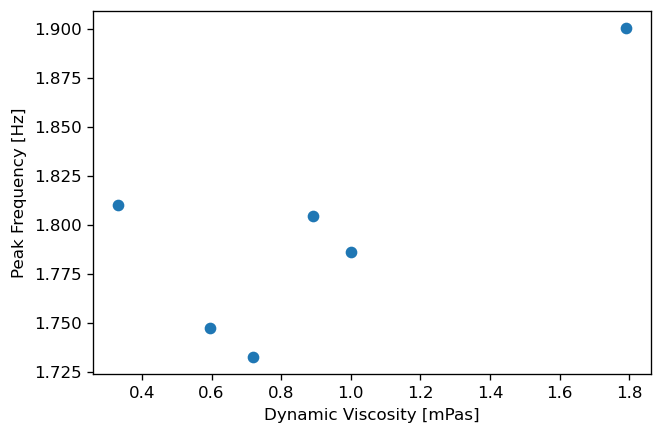

In [56]:
plt.scatter(mus_nearest, f_peaks)
plt.xlabel('Dynamic Viscosity [mPas]')
plt.ylabel('Peak Frequency [Hz]')
plt.show()

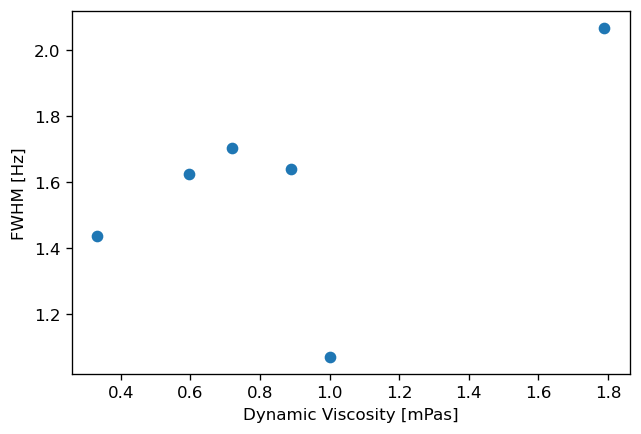

In [58]:
plt.scatter(mus_nearest, fwhms)
plt.xlabel('Dynamic Viscosity [mPas]')
plt.ylabel('FWHM [Hz]')
plt.show()

this is what you get when you analyse from the sinusoidal motion
Honey is an outlier due to its non-newtonian nature

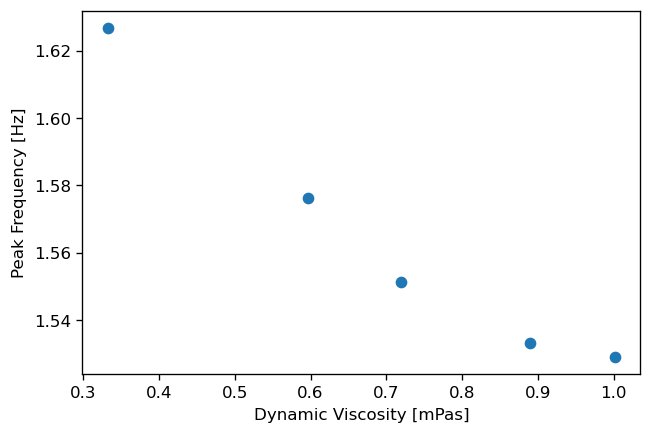

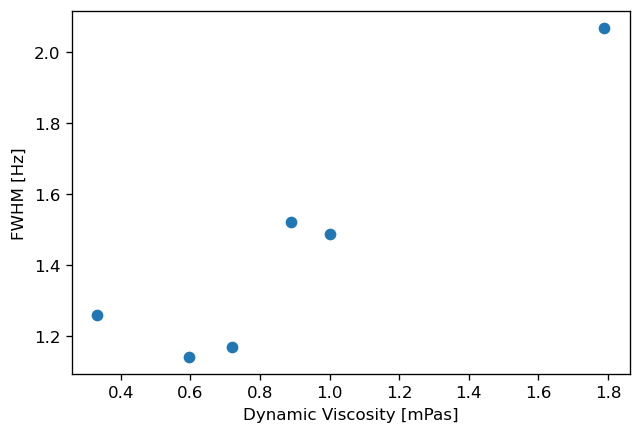

In [79]:
names = ['w20', 'w25', 'w35', 'w45', 'w85', 'm', 'h'] # in degrees C
mus_nearest = [1.0020, 0.8903, 0.7195, 0.5963, 0.3323, 1.79] # in mPas
mus_LinearInterpolation = []
f_peaks = [fp_w20, fp_w25, fp_w35, fp_w45, fp_w85, fp_milk]
fwhms = [fwhm_w20, fwhm_w25, fwhm_w35, fwhm_w45, fwhm_w85, fwhm_milk]

plt.scatter(mus_nearest[:-1], f_peaks[:-1])
plt.xlabel('Dynamic Viscosity [mPas]')
plt.ylabel('Peak Frequency [Hz]')
plt.show()

plt.scatter(mus_nearest, fwhms)
plt.xlabel('Dynamic Viscosity [mPas]')
plt.ylabel('FWHM [Hz]')
plt.show()

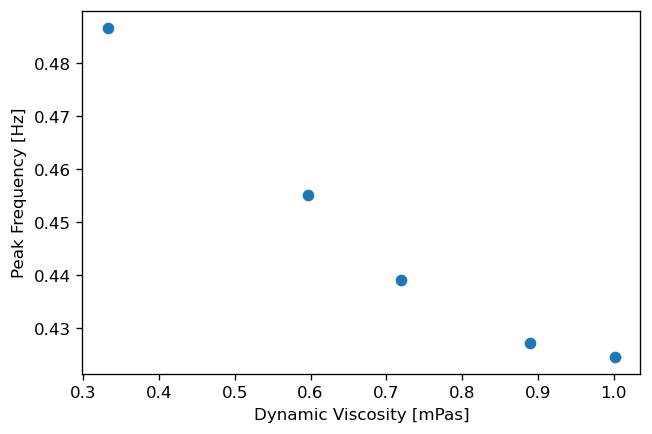

In [85]:
plt.scatter(mus_nearest[:-1], [np.log(f) for f in f_peaks[:-1]])
plt.xlabel('Dynamic Viscosity [mPas]')
plt.ylabel('Peak Frequency [Hz]')
plt.show()

alpha:  1.5256806122064952
beta:  0.05840681594627369


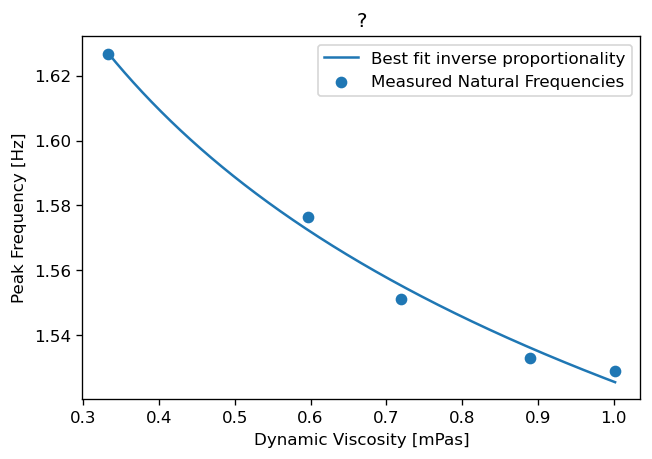

In [86]:
def inv_prop(x, alpha, beta):
    return alpha/(x**beta)

def lorentzian(f, f0, A, gamma):
    return A * gamma**2 / (gamma**2 + (f-f0)**2)

initial_values = np.array([1, 1])
popt, pcov = optimize.curve_fit(inv_prop, 
                        mus_nearest[:-1],
                        f_peaks[:-1],
                        absolute_sigma=True, # Don't forget this!
                        p0=initial_values,
                        maxfev=500000)

alpha_solution, beta_solution = popt

print('alpha: ', alpha_solution)
print('beta: ', beta_solution)

smooth_muvals = np.linspace(min(mus_nearest[:-1]), max(mus_nearest[:-1]), 1000) 
smooth_inv = inv_prop(smooth_muvals, *popt)

plt.title(f'?')
plt.scatter(mus_nearest[:-1], f_peaks[:-1], label="Measured Natural Frequencies")
plt.plot(smooth_muvals, smooth_inv, label="Best fit inverse proportionality")
plt.xlabel('Dynamic Viscosity [mPas]')
plt.ylabel('Peak Frequency [Hz]')

plt.legend()
plt.show()

alpha:  1.6728374037337266
beta:  -0.09601684180433764


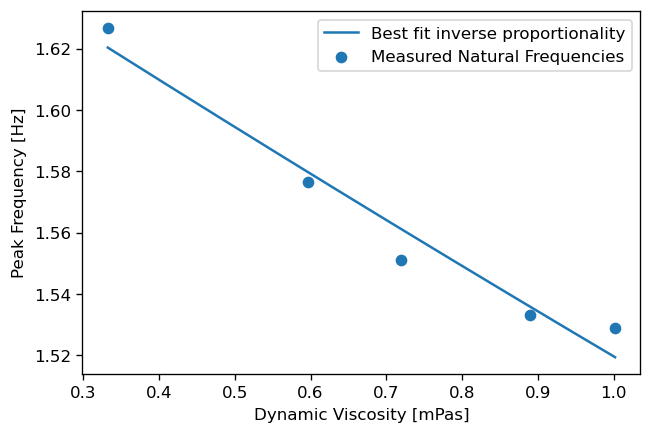

In [89]:
def exp_decay(x, alpha, beta):
    return alpha*np.e**(x*beta)


initial_values = np.array([1, 1])
popt, pcov = optimize.curve_fit(exp_decay, 
                        mus_nearest[:-1],
                        f_peaks[:-1],
                        absolute_sigma=True, # Don't forget this!
                        p0=initial_values,
                        maxfev=500000)

alpha_solution, beta_solution = popt

print('alpha: ', alpha_solution)
print('beta: ', beta_solution)

smooth_muvals = np.linspace(min(mus_nearest[:-1]), max(mus_nearest[:-1]), 1000) 
smooth_inv = exp_decay(smooth_muvals, *popt)

plt.scatter(mus_nearest[:-1], f_peaks[:-1], label="Measured Natural Frequencies")
plt.plot(smooth_muvals, smooth_inv, label="Best fit inverse proportionality")
plt.xlabel('Dynamic Viscosity [mPas]')
plt.ylabel('Natural Frequency [Hz]')

plt.legend()
plt.show()

m:  -0.15012718864029792
c:  1.669583852216089


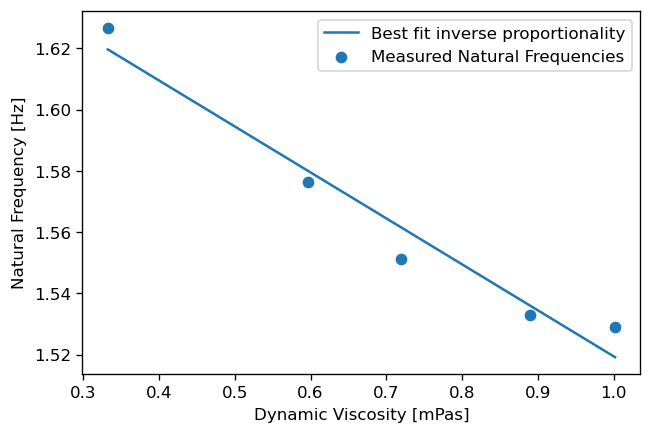

In [90]:
def linear(x, m, c):
    return m*x + c


initial_values = np.array([1, 1])
popt, pcov = optimize.curve_fit(linear, 
                        mus_nearest[:-1],
                        f_peaks[:-1],
                        absolute_sigma=True, # Don't forget this!
                        p0=initial_values,
                        maxfev=500000)

m_sol, c_sol = popt

print('m: ', m_sol)
print('c: ', c_sol)

smooth_muvals = np.linspace(min(mus_nearest[:-1]), max(mus_nearest[:-1]), 1000) 
smooth_lin = linear(smooth_muvals, *popt)

plt.scatter(mus_nearest[:-1], f_peaks[:-1], label="Measured Natural Frequencies")
plt.plot(smooth_muvals, smooth_lin, label="Best fit inverse proportionality")
plt.xlabel('Dynamic Viscosity [mPas]')
plt.ylabel('Natural Frequency [Hz]')

plt.legend()
plt.show()

Oscillatory damping behaviour

[0.      0.00375 0.0375  0.07125 0.10375 0.1375  0.17125 0.20375 0.2375
 0.27125 0.30375 0.3375  0.37125 0.40375 0.4375  0.47125 0.50375 0.5375
 0.57125 0.60375 0.6375  0.67125 0.70375 0.77125 0.80375 0.8375  0.87125
 0.90375 0.9375  0.97125 1.00375 1.0375  1.07125 1.10375 1.1375  1.17125
 1.20375 1.2375  1.27125 1.30375 1.3375  1.37125 1.4     1.4375  1.47125
 1.5375  1.57125 1.60375 1.6375  1.67125 1.70375 1.7375  1.77125 1.80375
 1.8375  1.87125 1.9375  1.97125 2.00375 2.0375  2.07125]
minimised chi-squared = 4121.038990384776
reduced chi^2 = 71.05239638594442
P(chi^2_min, DoF) = 0.0


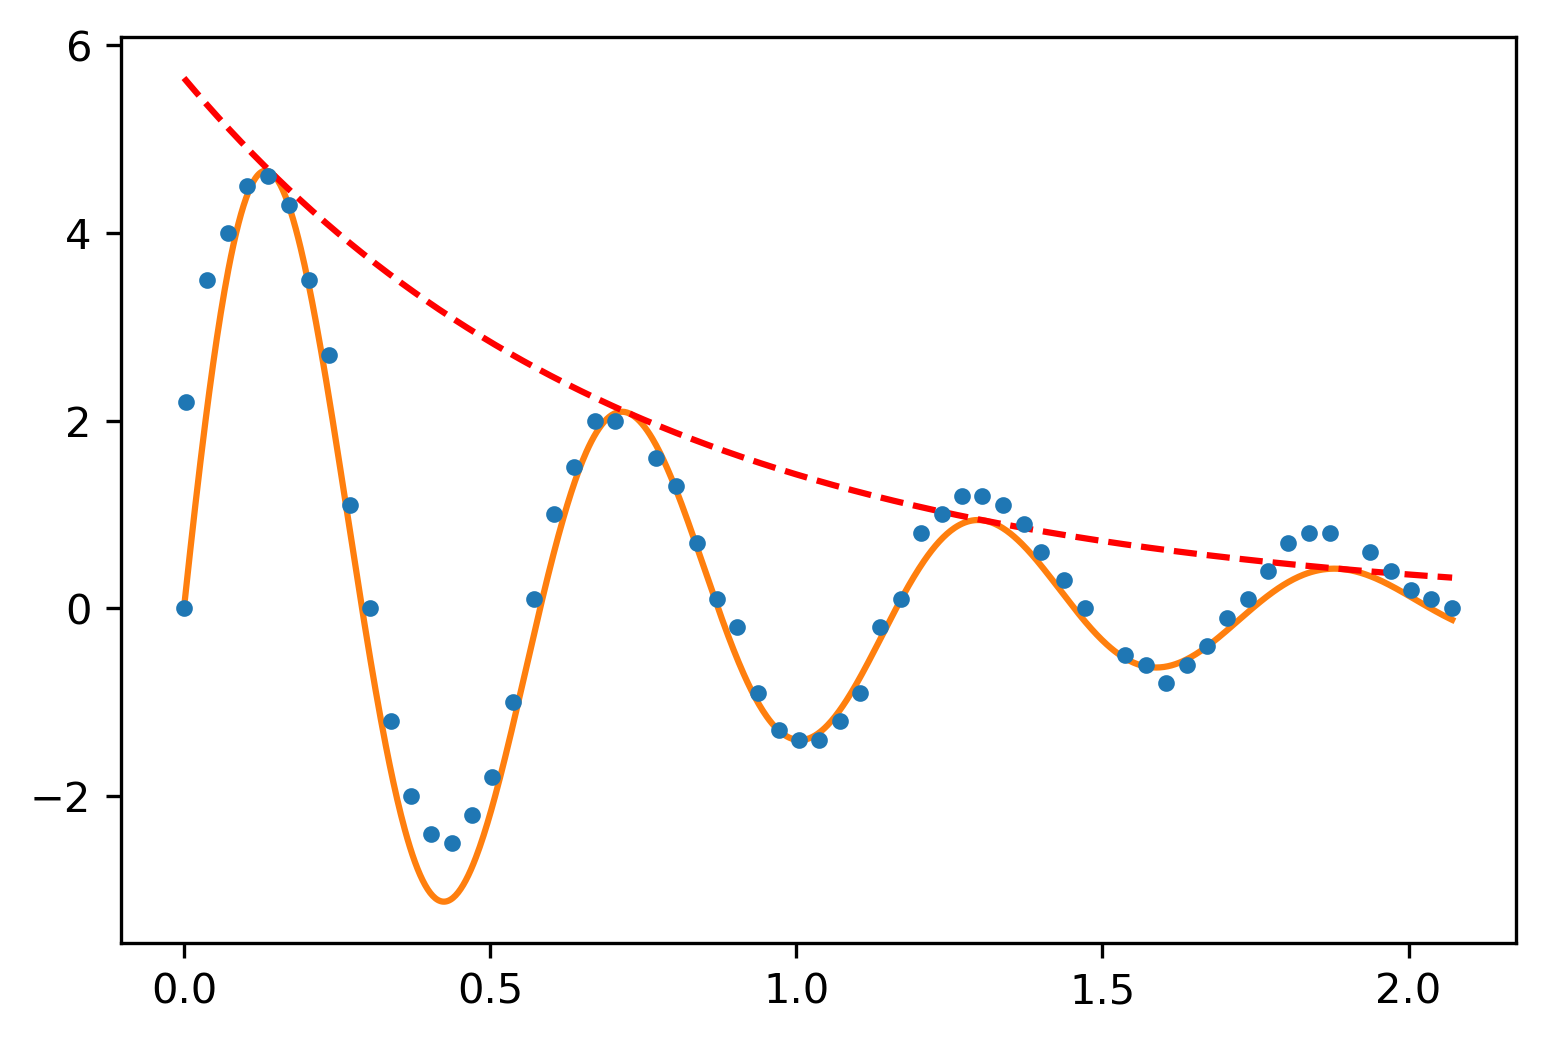

In [415]:
# temp = '25,9'
# file_dir = './'
filename= f'envelope.txt'
data = np.genfromtxt(filename,delimiter='\t',skip_header=2 )
time_data = data[:,0]
z_data = data[:,1]
timeshift = 0.24125
time_data_clean = time_data[np.isfinite(z_data)]-timeshift # cleaned data includes the timeshift, and removes any instances of infinite.
z_data_clean = z_data[np.isfinite(z_data)]
z_err = np.array([0.05]*len(z_data_clean))
print(time_data_clean)
plt.errorbar(time_data_clean,z_data_clean, yerr=z_err, fmt='.', label='25 ℃')

# Fiiting

# # FFT on best fit model
# def damped_sin(t, *param_vals):
#     return param_vals[0]*np.sin(param_vals[1]*t)*np.exp(-param_vals[2]*t )

# def power_decay(t, *param_vals):
#     return param_vals[0]*np.sin(param_vals[1]*t)/(t**param_vals[2])

# # CHOOSE 3 PARAMETER MODEL HERE
# model_function = damped_sin


initial_values = np.array([5, 11, 1]) 
deg_freedom = time_data_clean.size - initial_values.size # Make sure you understand why!
# print('DoF = {}'.format(deg_freedom))

# popt, pcov = optimize.curve_fit(model_function, 
#                        time_data_clean_25,
#                        z_data_clean_25,
#                        sigma=z_err,
#                        absolute_sigma=True, # Don't forget this!
#                        p0=initial_values,
#                        maxfev=500000)

# print('optimised parameters array popt = {}'.format(popt))

# a_solution, w_solution, b_solution = popt

# or equivalently,
# a_solution = popt[0]
# b_solution = popt[1]

# if model_function == damped_sin:
#     print('For oscillations of the form Asin(wt)*e^(bt)')
#     print('best fit A = {} '.format(a_solution))
#     print('best fit w = {} '.format(w_solution))
#     print('best fit b = {} '.format(b_solution))

# if model_function == power_decay:
#     print('For oscillations of the form Asin(wt)/(t^b)')
#     print('best fit A = {} '.format(a_solution))
#     print('best fit w = {} '.format(w_solution))
#     print('best fit b = {} '.format(b_solution))


def xl(t):
    return 5.6476533*np.sin(10.80224595*t)*np.e**(-1.375990315*t)

def xl(t, *param_vals):
    return param_vals[0]*np.sin(param_vals[1]*t)*np.e**(param_vals[2]*t)


# CHI-SQUARED ANALYSIS
def chi_squared(model_params, model, x_data, y_data, y_error):
    return np.sum(((y_data - model(x_data, *model_params))/y_error)**2)
chisq_min = chi_squared([5.6476533, 10.80224595, -1.375990315], # pass the array - no need to unpack
                        xl, 
                        time_data_clean, 
                        z_data_clean, 
                        z_err)

print('minimised chi-squared = {}'.format(chisq_min))

chisq_reduced = chisq_min/deg_freedom
print('reduced chi^2 = {}'.format(chisq_reduced))

import scipy.stats

P_value = scipy.stats.chi2.sf(chisq_min, deg_freedom)
print('P(chi^2_min, DoF) = {}'.format(P_value))

def xl(t):
    return 5.6476533*np.sin(10.80224595*t)*np.e**(-1.375990315*t)

def decay(t):
    return 5.6476533*np.e**(-1.375990315*t)

smooth_tvals = np.linspace(min(time_data_clean), max(time_data_clean), 1000)
# simulated_line = model_function(smooth_tvals, *popt) # unpack popt!
simulated_line = xl(smooth_tvals)
simulated_envelope = decay(smooth_tvals)
plt.plot(smooth_tvals, simulated_line)
plt.plot(smooth_tvals, simulated_envelope, 'r--')

Simple exponential decay from solving a linear 2nd order ODE shows a better fit for later oscillations (in terms of phase) than the newtonian model's numerical solution, but in this case it under estimates oscillations in the later regime.

---

## Numerical Solutions
By defining $\vec{Z}$ as
$$
\vec{Z} = \begin{pmatrix} z \\ \frac{\textrm{d}z}{\textrm{d}t} \end{pmatrix} \implies \frac{\textrm{d}\vec{Z}}{\textrm{d}t} = \begin{pmatrix} \frac{\textrm{d}z}{\textrm{d}t} \\ \frac{\textrm{d}^2z}{\textrm{d}t^2} \end{pmatrix}
$$

And plugging in the second order non-linear ODE we derived,

$$
\frac{\textrm{d}\vec{Z}}{\textrm{d}t} = \begin{pmatrix} \frac{\textrm{d}z}{\textrm{d}t} \\ \frac{- (\frac{\textrm{d}z}{\textrm{d}t})^2 + g(z-h) +b' \frac{\textrm{d}z}{\textrm{d}t}}{z} \end{pmatrix}
$$


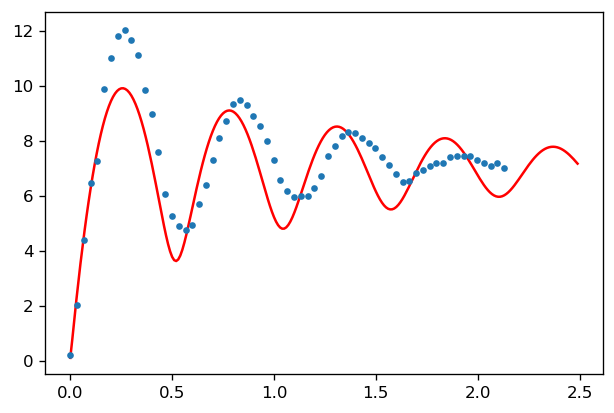

In [184]:
g = 9.8*100
def DZdt_Newt(Z, t, h, b):
    return [Z[1], -Z[1]**2/Z[0] - g +g*h/Z[0] -b*Z[1]/Z[0]]


plt.errorbar(time_data_clean,z_data_clean, yerr=z_err, fmt='.')


t_soln_newt = time_data_clean
t_soln_newt = np.arange(0, 2.5, 0.01)
# need to chi square optimize b
Z_intial = [0.1, 0]
Z_soln_Newton = sp.integrate.odeint(DZdt_Newt, Z_intial, t_soln_newt, args=(7,9))
z_soln_Newton = Z_soln_Newton[:,0]
plt.plot(t_soln_newt,z_soln_Newton,'r',label='Newtonian model')




Avergae interval between samples:  0.03328434628392074
Average sampling frequency:  30.044153232568902


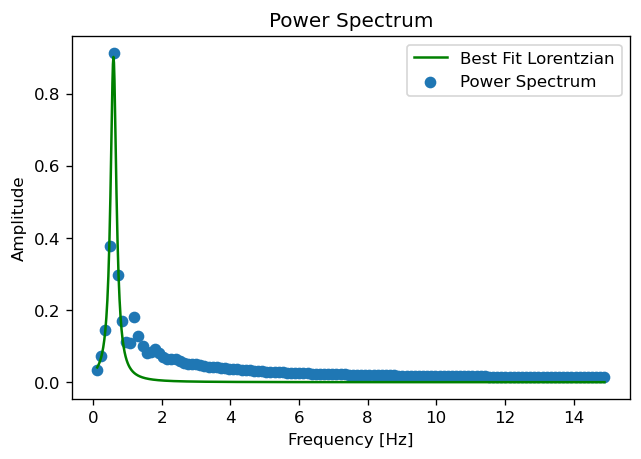

Peak of Lorentzian Profile = 0.59 Hz
FWHM = 0.21 Hz
Amplitude = 0.90


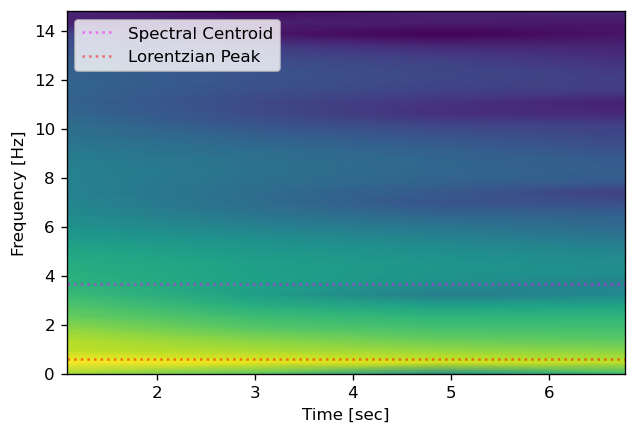

In [189]:
# FFT on raw data
# calculate avergae sampling rate
sum = 0
for i in range(len(time_data_clean)-1):
    sum += time_data_clean[i+1]-time_data_clean[i]


avg_time_between_samples = sum/(len(time_data_clean)-1)
print('Avergae interval between samples: ', avg_time_between_samples)

samplingFrequency   = 1/avg_time_between_samples
print('Average sampling frequency: ', samplingFrequency)


# # Compute Fourier transform for Power Spectrum
# zs = z_soln_Newton
# ts = t_soln_newt

# fourierTransform = np.fft.fft(zs)/len(zs)           # Normalize amplitude
# fourierTransform = fourierTransform[range(int(len(zs)/2))] # Exclude sampling frequency

# tpCount     = len(zs)
# values      = np.arange(int(tpCount/2))
# timePeriod  = tpCount/samplingFrequency
# frequencies = values/timePeriod

# # Frequency domain representation
# # ignore peak at 0 Hz - this is caused by DC signal bias
# # occurs when the signal encloses more area above the time axis than below
# fourierTransform = fourierTransform[1:]
# frequencies = frequencies[1:]

# # Lorentzian profile to fit Power spectrum
# def lorentzian(f, f0, A, gamma):
#     return A * gamma**2 / (gamma**2 + (f-f0)**2)

# initial_values = np.array([1, 1, 1])
# popt, pcov = optimize.curve_fit(lorentzian, 
#                         frequencies,
#                         abs(fourierTransform),
#                         absolute_sigma=True, # Don't forget this!
#                         p0=initial_values,
#                         maxfev=500000)

# f0_solution, A_solution, gamma_solution = popt

# smooth_fvals = np.linspace(min(frequencies), max(frequencies), 1000) 
# smooth_lorentz = lorentzian(smooth_fvals, *popt)  

# max_freq_component = frequencies[np.argmax(abs(fourierTransform))]
# plt.title(f'Power Spectrum')
# plt.scatter(frequencies, abs(fourierTransform), label='Power Spectrum')
# plt.plot(smooth_fvals, smooth_lorentz, label='Best Fit Lorentzian', color='g')
# # x1,x2,y1,y2 = plt.axis()  
# # plt.axis((0,10,y1,1))
# plt.xlabel('Frequency [Hz]')
# plt.ylabel('Amplitude')

# plt.legend()
# plt.show()

# print(f'Peak of Lorentzian Profile = {f0_solution:0.2f} Hz')
# print(f'FWHM = {2*gamma_solution:0.2f} Hz')
# print(f'Amplitude = {A_solution:0.2f}')
# fp_w20 = f0_solution # water at 20 degrees peak freq
# fwhm_w20 = 2*gamma_solution


# def centroid(fs, xs):
#     return (np.dot(fs, xs)/np.sum(xs))

# spec_cent = centroid(frequencies, abs(fourierTransform))

# f, t, Sxx = signal.spectrogram(z_soln_Newton, samplingFrequency, nperseg=65)
# plt.pcolormesh(t, f, np.log(Sxx), shading='gouraud')
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.axhline(y=spec_cent, color='fuchsia', linestyle=':', label='Spectral Centroid', alpha=0.5)
# plt.axhline(y=f0_solution, color='r', linestyle=':', label='Lorentzian Peak', alpha=0.5)
# plt.legend(loc='upper left')
# plt.show()

13.403776108115544


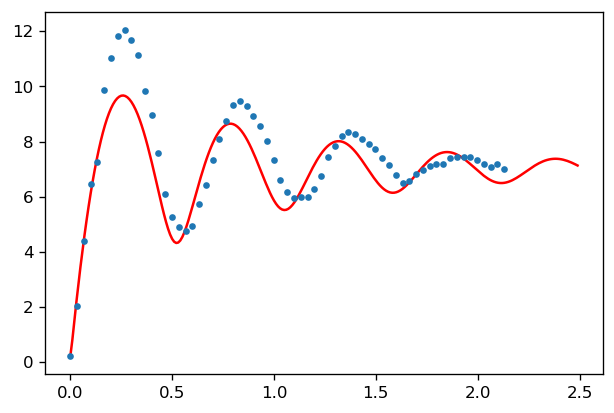

In [198]:
Z_intial = [z_data_clean[0], 0]
# Z_intial = [0.1, 0]
h=7
def Newt_solver(tsoln, b):
    return sp.integrate.odeint(DZdt_Newt, Z_intial, tsoln, args=(h,b))[:,0]

plt.errorbar(time_data_clean,z_data_clean, yerr=z_err, fmt='.')

initial_values = np.array([1])
popt, pcov = optimize.curve_fit(Newt_solver, 
                        time_data_clean,
                        z_data_clean,
                        absolute_sigma=True, # Don't forget this!
                        p0=initial_values,
                        maxfev=500000)

b_solution = popt[0]

print(b_solution)
t_soln = np.arange(0, 2.5, 0.01)


z_soln = sp.integrate.odeint(DZdt_Newt, Z_intial, t_soln, args=(h,b_solution))[:,0]
plt.plot(t_soln,z_soln,'r',label='Newtonian model')





# plt.legend()

<ErrorbarContainer object of 3 artists>

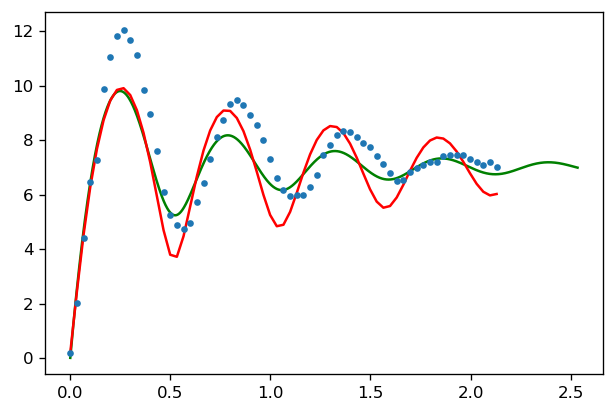

In [179]:
def DZdt_Loren(Z, t, omega):
    if Z[1]>0:
        return [Z[1], 1/Z[0] - 1 -omega*Z[1] - (Z[1])**2/Z[0]]
    else:
        return [Z[1], 1/Z[0] - 1 -omega*Z[1] ]

def Lorenc_solver(t, omega):
    return sp.integrate.odeint(DZdt_Loren, Z_intial, t, args=(omega,))[:,0]

# Z_intial = [z_data_clean[0], 0]
# Z_intial = [0.1, 0]
# initial_values = np.array([1])
# popt, pcov = optimize.curve_fit(Lorenc_solver, 
#                         time_data_clean,
#                         z_data_clean,
#                         absolute_sigma=True, # Don't forget this!
#                         p0=initial_values,
#                         maxfev=500000)

# omega_solution = popt[0]
t_soln = np.arange(0, 30, 0.01)
Z_intial = [0.001, 1]
# print(omega_solution)
z_soln_L = sp.integrate.odeint(DZdt_Loren, Z_intial, t_soln, args=(2.6*0.062,))[:,0]*h
plt.plot(t_soln*(h*1e-2/9.8)**0.5,z_soln_L,'g',label='Lorenceau model')
plt.plot(t_soln_newt,z_soln_Newton,'r',label='Newtonian model')
plt.errorbar(time_data_clean,z_data_clean, yerr=z_err, fmt='.')

In [116]:
popt[0]

-3.4135795826600326

---

Chi squared as a function of viscosity - i.e. which viscosity (vary viscosity either through edifferent liquids or through same liquid at different termperatures) does the theory describe the best?

---

## Fitting Oscillatory motion to Analytical Models

In [ ]:
def cut_jump(ts, zs, equil):
    for z in zs:
        if z < equil:
            zs = zs[1:]
            ts = ts[1:]

        elif z >= equil:
            break

    return ts, zs

In [ ]:
plt.plot(time_data_clean, z_data_clean)

In [ ]:
ts, zs = cut_jump(time_data_clean, z_data_clean, 7)
plt.plot(ts, zs)

In [ ]:
# DEFINE MODELS TO CHOOSE FROM
def damped_sin(t, *param_vals):
    return param_vals[0]*np.sin(param_vals[1]*t + param_vals[2])*np.exp(-param_vals[3]*t ) + param_vals[4]

def power_decay(t, *param_vals):
    return param_vals[0]*np.sin(param_vals[1]*t)/(t**param_vals[2])

In [ ]:
# CHOOSE A 3-PARAMETER MODEL HERE
model_function = damped_sin

if model_function == damped_sin:

    # ignore t=0 data point to avoid division by 0 error

    initial_values = np.array([1, 1, 1, 1, 1]) 
    deg_freedom = time_data_clean[1:].size - initial_values.size # Make sure you understand why!
    print('DoF = {}'.format(deg_freedom))

    popt, pcov = optimize.curve_fit(model_function, 
                        time_data_clean[1:],
                        z_data_clean[1:],
                        sigma=z_err[1:],
                        absolute_sigma=True, # Don't forget this!
                        p0=initial_values,
                        maxfev=500000)

    print('optimised parameters array popt = {}'.format(popt))

    a_solution, w_solution, phi_solution, b_solution, c_solution = popt

    print('For oscillations of the form Asin(wt + phi)*e^(bt) + c')
    # replace c (what you're oscillating bout) with the equlibrium value of fluid you calculate
    print('best fit A = {} '.format(a_solution))
    print('best fit w = {} '.format(w_solution))
    print('best fit phi = {} '.format(phi_solution))
    print('best fit b = {} '.format(b_solution))
    print('best fit c = {} '.format(c_solution))

if model_function == power_decay:

    # ignore t=0 data point to avoid division by 0 error

    initial_values = np.array([1, 1, 1]) # fit is sometimes dependnat on where you initialise
    deg_freedom = time_data_clean[1:].size - initial_values.size # Make sure you understand why!
    print('DoF = {}'.format(deg_freedom))

    popt, pcov = optimize.curve_fit(model_function, 
                        time_data_clean[1:],
                        z_data_clean[1:],
                        sigma=z_err[1:],
                        absolute_sigma=True, # Don't forget this!
                        p0=initial_values,
                        maxfev=50000)

    print('optimised parameters array popt = {}'.format(popt))

    a_solution, w_solution, b_solution = popt

    print('For oscillations of the form Asin(wt)/(t^b)')
    print('best fit A = {} '.format(a_solution))
    print('best fit w = {} '.format(w_solution))
    print('best fit b = {} '.format(b_solution))


def chi_squared(model_params, model, x_data, y_data, y_error):
    return np.sum(((y_data - model(x_data, *model_params))/y_error)**2)

chisq_min = chi_squared(popt, # pass the array - no need to unpack
                        model_function, 
                        time_data_clean[1:],
                        z_data_clean[1:],
                        z_err[1:],)

print('minimised chi-squared = {}'.format(chisq_min))

chisq_reduced = chisq_min/deg_freedom
print('reduced chi^2 = {}'.format(chisq_reduced))

P_value = stats.chi2.sf(chisq_min, deg_freedom)
print('P(chi^2_min, DoF) = {}'.format(P_value))

Plot Fit

In [ ]:
smooth_tvals = np.linspace(min(time_data_clean), max(time_data_clean), 1000)   

plt.figure(figsize=(5,3))
plt.errorbar(time_data_clean,z_data_clean, yerr=z_err, fmt='.')
plt.xlabel('Time (s)')
plt.ylabel('Height (m)')


simulated_line = model_function(smooth_tvals, *popt) # unpack popt!
plt.plot(smooth_tvals, simulated_line, 'r')
plt.show()

## Fitting to Numerical ODE Solutions

In [ ]:
t_solution = smooth_tvals


---

We define the 0th column of the array Y as as $y$, 1th column of Z as $\dot{z}$. 

$$
\vec{Z} =  \begin{pmatrix}
z\\
\dot{z}
\end{pmatrix}
$$

Then our defined function DZ_dt returns the derivatives of the array Y: 

$$
\dot{\vec{Z}}=\begin{pmatrix}
\dot{z}\\ 
\ddot{z}
\end{pmatrix}
$$
as the right hand side of our ordinary differential equation, where $\ddot{z}$ is filled in for the derived expression in the differential equation.

The function odeint from scipy can solve this for $z(t)$. 

In [103]:
# Solving the Newton's law model and also equations 17a and 17b from Lorenceau paper:


# Newton's law model
def DZ_dt_Newton(Z, t,args):
    h = args[0]
    g = args[1]
    b = args[2]
    return [Z[1], -Z[1]**2/Z[0] - g +g*h/Z[0] -b*Z[1]/Z[0] ]

# Lorenceau model:
def DZ_dt_Lor(Z, t,args):
    h = args[0]
    g = args[1]
    Omeg = args[3]
    if Z[1]>0:
        return [Z[1], 1/Z[0] - 1 -Omeg*Z[1] - (Z[1])**2/Z[0]]
    else:
        return [Z[1], 1/Z[0] - 1 -Omeg*Z[1] ]


def plot_osc(h=7.0, g=9.8e2,b = 23,factor=2.60):

    # prepare data for plotting:
    z_data1 = z_data_clean # change the overall level so that bottom of straw is z=0
    time_axis1 = time_data_clean  # only include data for positive times (after cap is released)
    
    # prepare parameters for solving models:
    Omeg = 0.062*factor
    params = (h,g,b,Omeg)    
    
    # solve Newton model:
    t_soln = time_axis1
    Z_soln_Newton = sp.integrate.odeint(DZ_dt_Newton, [0.02, 0], t_soln, args=(params,))   

    z_soln_Newton = Z_soln_Newton[:,0]      # fluid height
#     ydot_soln_Newton = Y_soln_Newton[:,1]   # fluid velocity

    # solve Lorenceau model, equation 17a and 17b....
    t_solnLor = np.arange(0, 30, 0.01)
    Z_soln_Lor = sp.integrate.odeint(DZ_dt_Lor, [0.02, 0.00], t_solnLor, args=(params,))   
    
    z_soln_Lor = Z_soln_Lor[:,0]*h       # fluid height

    Omeg = 0.062*factor
    params = (h,g,b,Omeg)

    plt.clf()
    plt.plot(time_axis1,z_data1,'b.',label='Data') 
    plt.plot(t_soln,z_soln_Newton,'r',label='Newtonian model')

    plt.xlabel('time (sec)',fontsize=15)
    plt.ylabel('fluid level (cm)',fontsize=15)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)

    plt.plot(t_solnLor*(h*1e-2/9.8)**0.5,z_soln_Lor,'g--',label='Lorenceau model')
    plt.title('Fluid level oscillations with both models\nOmega=%2.2e (no unit), h=%2.2f, b=%2.2e\nfilename = %s'%(Omeg,h,b,filename),fontsize=15)
    plt.legend(frameon=False,loc=1)
    plt.xlim([-0.2,3])
    plt.grid()
#     plt.savefig('fluid oscillation with fits.png',dpi=400)
    plt.show()


   

interact(plot_osc, h=(0.0, 20.0),g=(5.0e2, 15.0e2),b=(0.0, 30.0));


interactive(children=(FloatSlider(value=7.0, description='h', max=20.0), FloatSlider(value=980.0, description=…

*NEW* Chi-squared analysis to find the best parameters:

In [ ]:
# DEFINE MODELS TO CHOOSE FROM
def damped_sin(t, *param_vals):
    return param_vals[0]*np.sin(param_vals[1]*t)*np.exp(-param_vals[2]*t )

def power_decay(t, *param_vals):
    return param_vals[0]*np.sin(param_vals[1]*t)/(t**param_vals[2])


# CHOOSE A 3-PARAMETER MODEL HERE
model_function = damped_sin


initial_values = np.array([5, 11, 1]) 
deg_freedom = time_data_clean.size - initial_values.size # Make sure you understand why!
print('DoF = {}'.format(deg_freedom))

popt, pcov = optimize.curve_fit(model_function, 
                       time_data_clean,
                       z_data_clean,
                       sigma=z_err,
                       absolute_sigma=True, # Don't forget this!
                       p0=initial_values)

print('optimised parameters array popt = {}'.format(popt))

a_solution, w_solution, b_solution = popt

if model_function == damped_sin:
    print('For oscillations of the form Asin(wt)*e^(bt)')
    print('best fit A = {} '.format(a_solution))
    print('best fit w = {} '.format(w_solution))
    print('best fit b = {} '.format(b_solution))

if model_function == power_decay:

    # ignore t=0 data point to avoid division by 0 error

    initial_values = np.array([5, 5, 1]) 
    deg_freedom = time_data_clean[1:].size - initial_values.size # Make sure you understand why!
    print('DoF = {}'.format(deg_freedom))

    popt, pcov = optimize.curve_fit(model_function, 
                        time_data_clean[1:],
                        z_data_clean[1:],
                        sigma=z_err[1:],
                        absolute_sigma=True, # Don't forget this!
                        p0=initial_values)

    print('optimised parameters array popt = {}'.format(popt))

    a_solution, w_solution, b_solution = popt

    print('For oscillations of the form Asin(wt)/(t^b)')
    print('best fit A = {} '.format(a_solution))
    print('best fit w = {} '.format(w_solution))
    print('best fit b = {} '.format(b_solution))


def chi_squared(model_params, model, x_data, y_data, y_error):
    return np.sum(((y_data - model(x_data, *model_params))/y_error)**2)
chisq_min = chi_squared(popt, # pass the array - no need to unpack
                        model_function, 
                        time_data_clean[1:],
                        z_data_clean[1:],
                        z_err[1:],)

print('minimised chi-squared = {}'.format(chisq_min))

chisq_reduced = chisq_min/deg_freedom
print('reduced chi^2 = {}'.format(chisq_reduced))

P_value = stats.chi2.sf(chisq_min, deg_freedom)
print('P(chi^2_min, DoF) = {}'.format(P_value))

The above result is exciting! Both models match data *pretty well*!!!

# Going further: examining the frequency spectrum
Our analysis so far captures most of the relevant physics. However, sometimes looking in the frequency domain can give insights that weren't readily available in time-domain analysis...

In [ ]:
# define all same things as above:

h = 10
g=980
b=23
factor=2.60

# prepare data for plotting:
z_data1 = z_data_clean[8:]+h # change the overall level so that bottom of straw is z=0
time_axis1 = time_data_clean[8:]  # only include data for positive times (after cap is released)

# prepare parameters for solving models:
Omeg = 0.062*factor
params = (h,g,b,Omeg)    

# solve Newton model:
t_soln = time_axis1
Z_soln_Newton = sp.integrate.odeint(DZ_dt_Newton, [0.02, 0], t_soln, args=(params,))   

z_soln_Newton = Z_soln_Newton[:,0]      # fluid height
#     ydot_soln_Newton = Y_soln_Newton[:,1]   # fluid velocity

# solve Lorenceau model, equation 17a and 17b....
t_solnLor = np.arange(0, 300, 0.01)
Z_soln_Lor = sp.integrate.odeint(DZ_dt_Lor, [0.02, 0.00], t_solnLor, args=(params,))   

z_soln_Lor = Z_soln_Lor[:,0]*h       # fluid height

Omeg = 0.062*factor
params = (h,g,b,Omeg)

plt.clf()
plt.plot(time_axis1,z_data1,'b.',label='Data') 
plt.plot(t_soln,z_soln_Newton,'r',label='Newtonian model')

plt.xlabel('time (sec)',fontsize=15)
plt.ylabel('fluid level (cm)',fontsize=15)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

plt.plot(t_solnLor*(h*1e-2/9.8)**0.5,z_soln_Lor,'g--',label='Lorenceau model')
plt.title('Fluid level oscillations with both models\nOmega=%2.2e (no unit), h=%2.2f, b=%2.2e\nfilename = %s'%(Omeg,h,b,filename),fontsize=15)
plt.legend(frameon=False,loc=1)
plt.xlim([-0.2,3])
plt.grid()
#     plt.savefig('fluid oscillation with fits.png',dpi=400)
plt.show()

In [ ]:
# plot solution for longer time so as to get denser data points in the frequency spectrum:

t_soln_sec = t_solnLor*(h*1e-2/9.8)**0.5
plt.clf()
# plt.plot(t_soln,z_soln_Newton,'r',label='ode solution')
plt.plot(t_solnLor*(h*1e-2/9.8)**0.5,z_soln_Lor,'r',label='ode solution')

plt.plot(time_axis1,z_data1,'b*',label='y data') 
# plt.xlim([-.1,5])
plt.show()
z_soln = z_soln_Lor

In [ ]:
# perform the discrete Fourier transform of the model which is fit to the data:

Z_FFT = np.fft.fft(z_soln-np.mean(z_soln))
z2 = Z_FFT * np.conjugate(Z_FFT)
pow = abs(z2[1:len(Z_FFT)//2] + z2[:len(Z_FFT)//2:-1])
pow = pow/np.max(pow)
DT = t_soln_sec[1]-t_soln_sec[0]   # sample time
freq = (np.fft.fftfreq(t_soln_sec.shape[0])/DT)[1:len(Z_FFT)//2]

In [ ]:
# check the power spectrum:

title = 'Power spectrum'
xaxis_label = 'frequency (Hz)'
yaxis_label = 'signal (a.u.)'

plt.plot(freq,pow,'.-')

plt.xlabel(xaxis_label,fontsize=15)
plt.ylabel(yaxis_label,fontsize=15)
plt.grid()
plt.title(title,fontsize=20)
plt.xlim([0,6])
# plt.savefig('power spectrum.png',dpi=400)
plt.show()

In [ ]:
m = np.argmax(pow)
freq[m]

Compare this peak value to the oscillation frequency that we can analytically derive in the limit of small oscillations:

$$ f = \frac{\omega}{2 \pi} = \frac{1}{2 \pi} \left ( \frac{g}{h} \right )^{1/2}$$

In [ ]:
h_guess = 10 # cm

In [ ]:
f_est = 1/(2*np.pi)*np.sqrt(g/h_guess)
print('small oscillation frequency = %2.3f Hz'%(f_est))

Fit the power spectrum with a Lorentzian function:

In [ ]:
def Lorentzian(x_val, h, w, x_c, y_0):
    return ((h * w**2)/((w**2)+(4*(x_val - x_c)**2)) + y_0)
h_g   = 1    #h = height
w_g   = 1        #w = fwhm
x_c_g = 1.5        #x_c = x val of peak
y_0_g = 0           #y_0 = y val of asymptote

fit_from_Hz = 0.5
fit_to_Hz = 2.5

fit_from_Hz = 1
fit_to_Hz = 2.5

fit_from = int(np.round(np.interp(fit_from_Hz,freq,np.arange(len(freq)))))
fit_to = int(np.round(np.interp(fit_to_Hz,freq,np.arange(len(freq)))))



#best fit lines (guesses help the process)
p_guess = [h_g, w_g, x_c_g, y_0_g]
peak, pcov = sp.optimize.curve_fit(Lorentzian, freq[fit_from:fit_to],pow[fit_from:fit_to], p0 = p_guess)

perr = np.sqrt(np.diag(pcov))
plt.plot(freq[:100],pow[:100],'bo',label = 'power spectrum')
# plt.plot(freq[:100], Lorentzian(freq[:100], *p_guess), 'g--',label='guess')
plt.plot(freq[:100], Lorentzian(freq[:100], *peak), 'r',label='Lorentzian fit')
plt.grid()

plt.axvline(x=f_est)
# plt.axvline(x=fit_to_Hz)
wdith_plot = 0.8
plt.xlim([peak[2]-wdith_plot,peak[2]+wdith_plot])
xaxis_label = 'frequency (Hz)'
yaxis_label = 'signal (a.u.)'
plt.xlabel(xaxis_label,fontsize=15)
plt.ylabel(yaxis_label,fontsize=15)
plt.legend(frameon=False,loc=2) 
plt.savefig('fig3 - frequency spectrum.png',dpi=400)
plt.show()

In [ ]:
print("Our fitted values using Lorentzian model:")
print("Height: %.9f"%(peak[0]),"a.u.")
print("FWHM : %.5f"%(peak[1]),"Hz")
print("Center: x =%.5f"%(peak[2]),"Hz")
print("Flatline: y =%.9f"%(peak[3]),"a.u.")
print()

In [ ]:
# the width of the power spectrum gives an estimate of the timescale of the decay:

FWHM = peak[1]
DT = 1/(FWHM)
print('The width of the power spectrum is %2.2f Hz which implies a decay time of DT=%2.2e sec'%(FWHM,DT))

In [ ]:
print('discrepancy bw small oscillations and measured peak is %2.2f %%'%((f_est - peak[2])/f_est*100))

# Further considerations:

Considering the viscosity of water -- 
If the time scale of motion is happening faster than a characteristic time scale given by T = (2nd page, 2nd paragraph of Lorenceau paper):

$$ \rho R^2/\eta$$

then it is not needed to include viscous dissipation along the walls of the tube. 

In [ ]:
eta = 1.002e-3 # Pa*sec
rho = 1000 # kg/m^3
R = 0.005 # meters

In [ ]:
timescale = rho* R**2/eta
timescale

25 seconds -- indeed, no need to worry about dissipation along the walls of the tube. Then it is all about the singular pressure loss at the tube opening at the bottom as eddies appear, dissipating energy

https://www.saylor.org/site/wp-content/uploads/2011/04/Viscosity.pdf


https://en.wikipedia.org/wiki/Laminar_flow

Also, we can calculate the kinematic viscosity of water, yeilding the Reynolds number:



In [ ]:
mu = 8.9e-4 # Pa*sec @ 25 deg C   
rho = 1000 # kg/m^3 density of water
nu =  mu/rho   # ν is the kinematic viscosity of the fluid, ν = (m2/s);
D = 10.8e-3    # DH is the hydraulic diameter of the pipe (m);
vymax = 0.2 # m/s  -- this is an estimate of the peak velocity, just from looking at the data.

Re = vymax *D/nu

print('Reynolds # = %2.2f'%(Re))

This Reynolds number is in an in-between the laminar and turbulent flow regimes at the very beginning, which may explain the discrepancy between the experimental data and the models. Both models assume a laminar flow regime, where linear 'channels' of water flow do not cross over each other. The remaining flow, with lower velocities, is in the laminar flow regime.

In [ ]:
# calculation of omega factor in Lorenceau, Eqn. 16.
omeg = 16*eta*(9.2e-2)**0.5/(rho*(0.010/2)**2 * 9.8**0.5)
omeg
# units check out to be unitless